# 期中專案

## 對PTT在1218公投案進行分析以及探討

- 課程：社群媒體分析
- 指導老師：黃三益 教授
- 八卦版 + 政黑板  2021-10-19 ~ 2021-11-27 PTT爬蟲
- 關鍵字：'重啟核四' '公投綁大選' '萊豬' '珍愛藻礁'
- 排除關鍵字：'罷免' '陳柏維'

## 動機與目的：
- 1218公投案即將舉行，通常公投事件常常有著正負兩種聲音，以及各自不同的支持論點，因此我們想了解在Ptt八卦版與政黑版上鄉民對於這件事情的看法以及真正關心的議題為何

In [1]:
# 確認當前工作目錄
#%pip install wordcloud
%pwd

'/home/zackary/Social/mid_project/final'

In [2]:
# 安裝會使用到的套件
#%pip install ckiptagger[tf,gdown] wordcloud tweepy==3.10.0 SnowNLP

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/frame

In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 2. 資料前處理


In [5]:
#匯入資料
MetaData = pd.read_csv('./raw_data/referendum_1128_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/referendum_1128_articleReviews.csv', encoding='UTF-8')

In [6]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(1)

共有 3600 篇文章


artTitle     artDate   artTime  \
0  Re:[新聞]林右昌拋「北海市」基隆拚升格！併新北7  2021/10/18  03:20:13   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634527215....    gasboy  Gossiping   

   commentNum  push  boo                                           sentence  
0           9     2    1  乾脆各縣市都合併起來，建一個中華台北，國際承認中華台北，中華台北有參加公投民意通\n過品質掛...

In [7]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(1)

共有 220288 個留言


artTitle     artDate   artTime  \
0  Re:[新聞]林右昌拋「北海市」基隆拚升格！併新北7  2021/10/18  03:20:13   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634527215....    gasboy  Gossiping   

  cmtPoster cmtStatus              cmtDate    cmtContent  
0   gay7788         →  2021-10-18 11:21:00  :直接叫中華台北蠻有梗ㄉ

In [8]:
# 再篩一次文章
keywords = ['重啟核四','公投綁大選','萊豬','珍愛藻礁','四個不同意','四個同意','1218','核四'] #'重啟核四' '公投綁大選' '萊豬' '珍愛藻礁'
toMatch = '|'.join(keywords)

In [9]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(2892, 10)


In [10]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [11]:
print(Reviews.shape)
Reviews.head(1)

(185528, 10)


artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo cmtContent  
0          26     7   12      :這臉無敵

### 2.2 資料清理  
- 去除NA值
- 正規化資料清理
- 去除不是中文的字詞

In [12]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
#只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))

In [13]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [14]:
def clean(row):  
    result = re.sub('[\t]{2,}', '', row)
    result = re.sub('#_*', '', result)
    result = re.sub('\\n', '', result)
    result = re.sub('\s{2,}', '', result)
    result = re.sub('(http|https)://.*', '', result)
    result = re.sub('(新聞|新聞來源|網址|網址媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除|新聞網址|新聞內容|附註|心得|來源)', '',result)
    result = re.sub('(http|https)://.*', '', result)
    return result

In [15]:
MetaData['sentence'] = MetaData.sentence.apply(clean)
MetaData.head(1)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...

In [16]:
Reviews['sentence'] = Reviews.cmtContent.apply(clean)
Reviews.head(1)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo cmtContent sentence  
0          26     7   12      :這臉無敵    :這臉無敵

### 2.3 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [17]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/referendum_user.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /home/zackary/Social/mid_project/final/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u4033ecc80f0bbdc025cfb98b1ce05411.cache
Loading model cost 1.525 seconds.
Prefix dict has been built successfully.


In [18]:
# 參數形式手動加入字詞
words = ['不同意']
for w in words:
    jieba.add_word(w, freq=20000, tag=None)

In [19]:
def getToken(row):    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [20]:
MetaData['word'] = MetaData.sentence.apply(getToken)
# 將word欄位展開
MetaData_token = MetaData.explode('word') 
MetaData_token.head(1)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

  word  
0   下台

In [21]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)
# 將word欄位展開
Reviews_token = Reviews.explode('word') 
Reviews_token.head(3)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
1  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo          cmtContent            sentence word  
0          26     7   12               :這臉無敵               :這臉無敵   這臉  
0          26     7   12               :這臉無敵               :這臉無敵   無敵  
1          26     7   12  :他早該下台了便宜的大蒜還在海上嗎?  :他早該下台了便宜的大蒜還在海上嗎?   早該

In [22]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

artDate                                             artUrl word
0  2021/10/18  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   下台
0  2021/10/18  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   僅次
0  2021/10/18  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  蘇貞昌
0  2021/10/18  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  吉仲能
0  2021/10/18  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   光榮

In [23]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [24]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  size
185301 2021-11-19   同意  1120
199618 2021-11-20   同意   904
43167  2021-10-30   台灣   751
189839 2021-11-19   核四   737
185580 2021-11-19   問題   676
13550  2021-10-26   公投   671
42311  2021-10-30   公投   667
47719  2021-10-30  民進黨   667
55086  2021-10-31   公投   609
55805  2021-10-31   台灣   603

## 3. lexicon-base 情緒分析
- 進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。
- 為了分析聲量，我們在此加入聲量字典(name)，以進行後續分析。

In [25]:
filepath = ['ntusd-negative','ntusd-positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

In [26]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

word      sentiments
0              幹  ntusd-negative
1          一下子爆發  ntusd-negative
2      一下子爆發的一連串  ntusd-negative
3            一巴掌  ntusd-negative
4             一再  ntusd-negative
...          ...             ...
11083         戀戀  ntusd-positive
11084         驚喜  ntusd-positive
11085         讚許  ntusd-positive
11086         讚賞  ntusd-positive
11087         煇煌  ntusd-positive

[11088 rows x 2 columns]

### 3.2 情緒字典與斷詞結果進行合併
- 將情緒字典與斷詞結果進行合併。

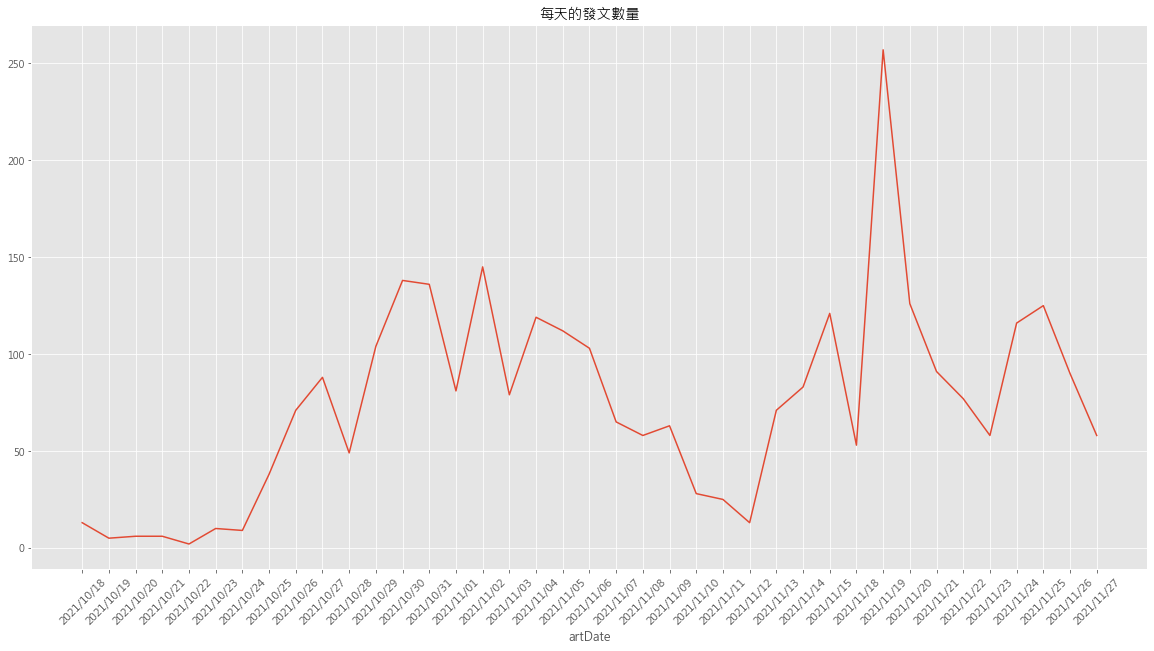

In [27]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(20,10))   # 顯示圖框架大小 (寬,高)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

- 發文最多數量最多的前三篇分為 10/30、11/02、11/19

### 3.3 正負向情緒及聲量分數折線圖
分別畫出文集中，正向（positive）、負向（negative）情緒與聲量的折線圖。

In [28]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

artDate      sentiments  size
0 2021-10-18  ntusd-negative   583
1 2021-10-18  ntusd-positive   269
2 2021-10-19  ntusd-negative   118
3 2021-10-19  ntusd-positive    83
4 2021-10-20  ntusd-negative   102

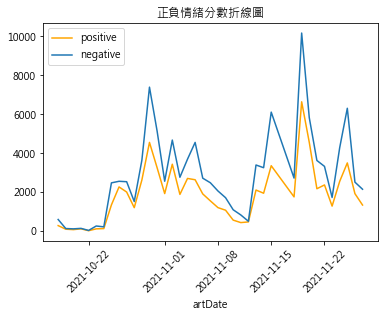

In [29]:
p = sentiment_count[sentiment_count['sentiments']=='ntusd-positive']
n = sentiment_count[sentiment_count['sentiments']=='ntusd-negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-11-19', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

- 畫出每天的情緒總分數，可以看到情緒以負面為主。 
- 10/30號11/19有最多聲量，約在11/6號之後討論度逐漸下降至11/11號後討論度又逐漸上升。

### 3.4 正負向情緒分數比例折線圖圖

In [30]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

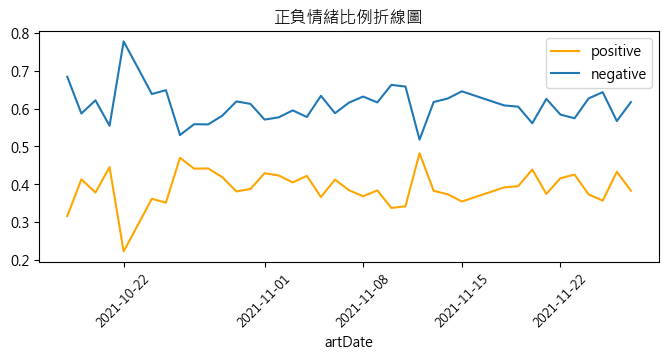

In [31]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/09/30']
p = sentiment_count_r[sentiment_count_r['sentiments']=='ntusd-positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='ntusd-negative']

plt.figure(figsize=(8,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend(loc=1) #顯示圖例
#plt.axvline(x=datetime.strptime('2021-10-17', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

### 3.5 文字雲
- 針對討論度最高的三天來畫出該天的文字雲，分別為10/30、11/02、11/19這三天。
- 如果文字雲中的字詞大小越大，代表出現頻率越高。

In [32]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

### 2021-10-30 文字雲


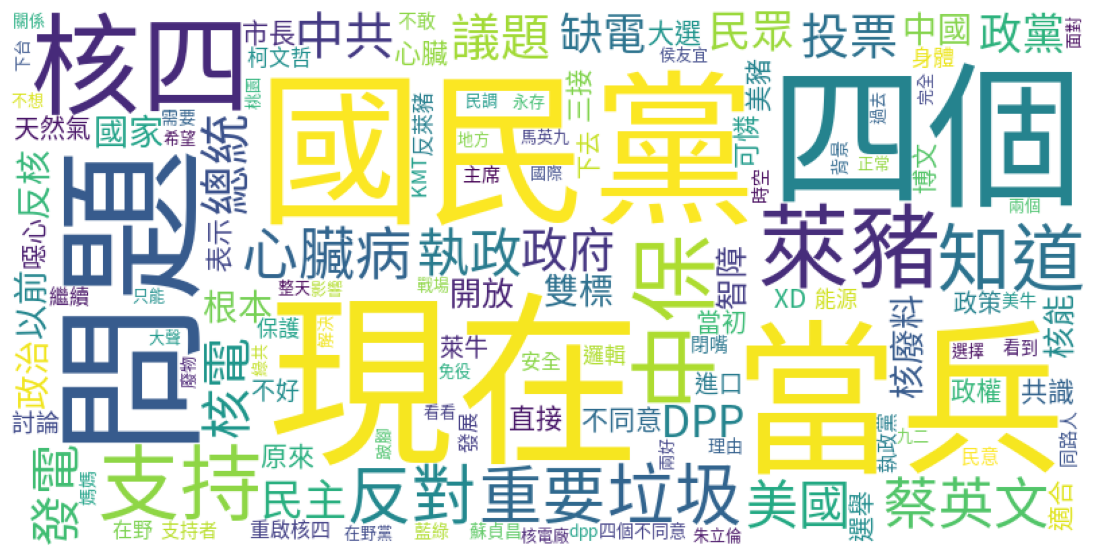

In [33]:
dict_1030 = Wc_dict(word_count,"2021-10-30",450,50)

font = '/home/zackary/font/SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1030)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-11-02 文字雲


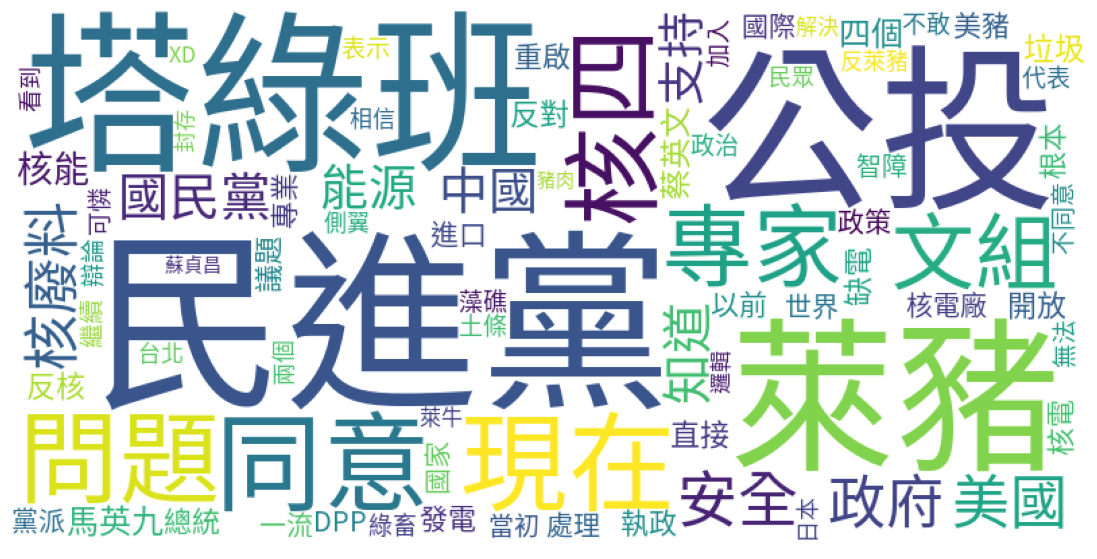

In [34]:
dict_1102 = Wc_dict(word_count,"2021-11-02",450,50)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1102)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

## 2021-11-19 文字雲

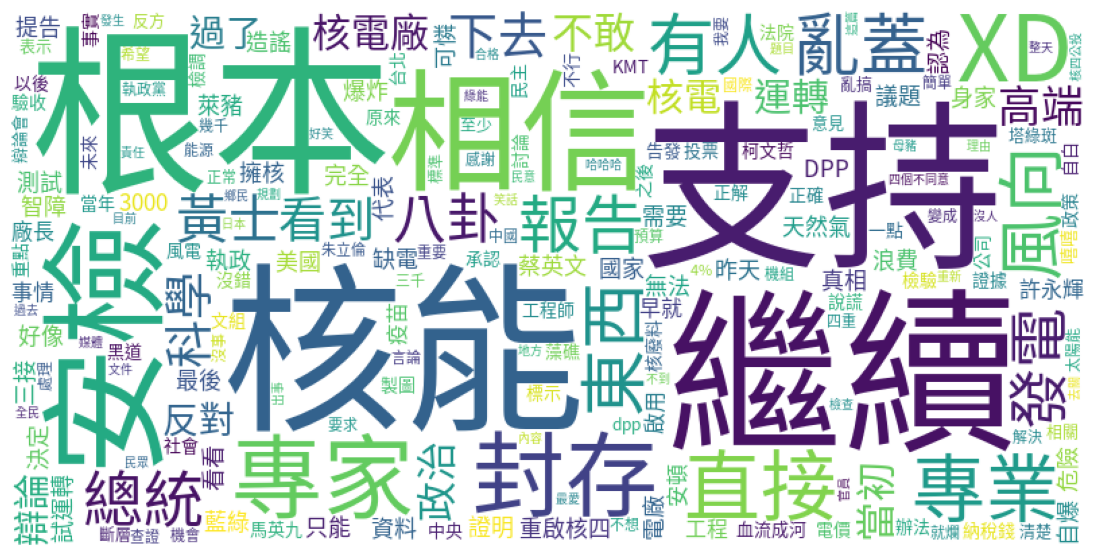

In [35]:
dict_1119 = Wc_dict(word_count,"2021-11-19",200,15)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1119)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字以及聲量字出現的詞頻，並找出情緒的代表字。

In [36]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

word      sentiments   size
223   問題  ntusd-negative  11818
212   同意  ntusd-positive   7471
245   垃圾  ntusd-negative   5078
695   知道  ntusd-positive   4176
295   安全  ntusd-positive   2535

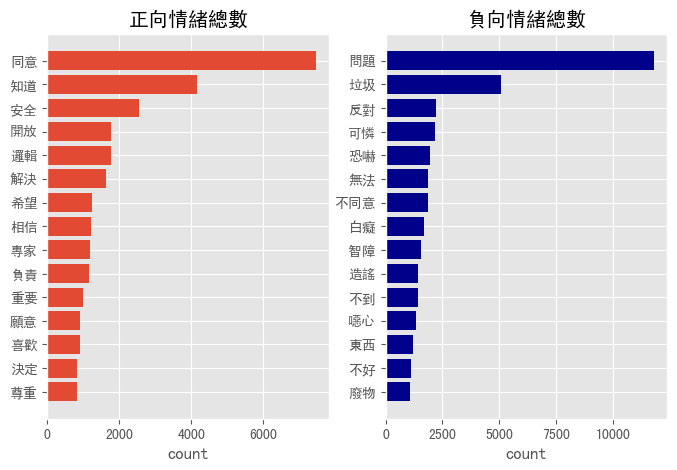

In [37]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

plt.show()

- 我們使用台大正負面情緒表來看正負情緒的總數
- 正向情緒前三個為：同意、知道、安全
- 負向情緒前三個為：問題、垃圾、反對

另外，也可以依據不同日期觀察情緒代表字的變化。
### 2021-10-30 正負情緒代表字

In [38]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_1030 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-30"].sort_values(by=['size'], ascending=False)
sentiment_1030.head()

artDate word      sentiments  size
1229 2021-10-30   問題  ntusd-negative   590
1227 2021-10-30   同意  ntusd-positive   552
1243 2021-10-30   垃圾  ntusd-negative   430
1455 2021-10-30   知道  ntusd-positive   215
1212 2021-10-30   反對  ntusd-negative   202

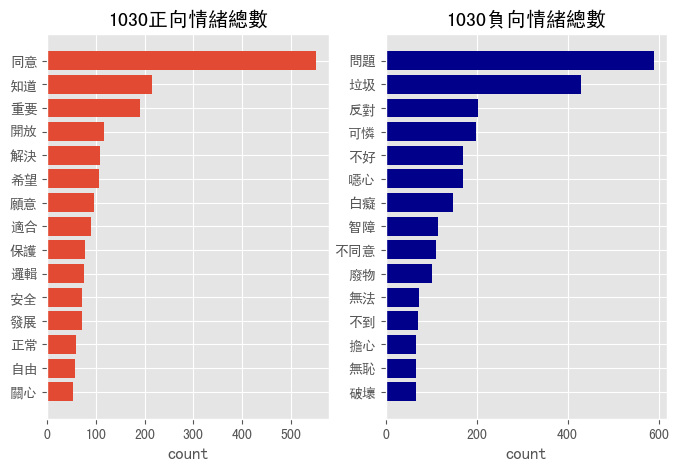

In [39]:
p_sum = sentiment_1030[sentiment_1030["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1030[sentiment_1030["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1030正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('1030負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2021-11-02 正負情緒代表字

In [40]:
#篩選日期
sentiment_1102 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-11-02"].sort_values(by=['size'], ascending=False)
sentiment_1102.head()

artDate word      sentiments  size
2270 2021-11-02   問題  ntusd-negative   504
2268 2021-11-02   同意  ntusd-positive   284
2281 2021-11-02   垃圾  ntusd-negative   260
2306 2021-11-02   專家  ntusd-positive   226
2297 2021-11-02   安全  ntusd-positive   215

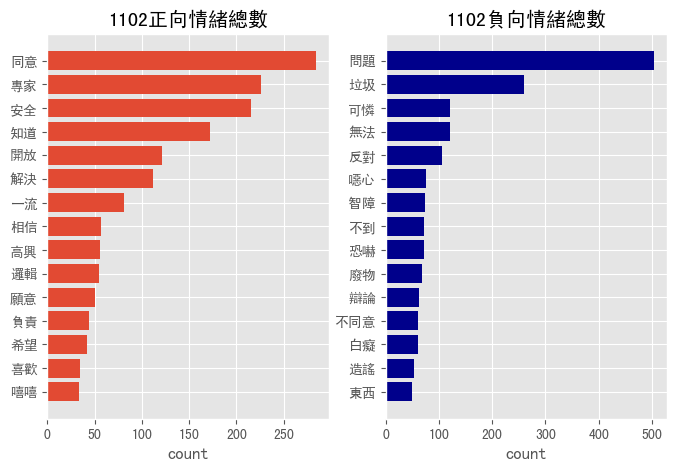

In [41]:
p_sum = sentiment_1102[sentiment_1102["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1102[sentiment_1102["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1102正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('1102負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2021-11-19 正負情緒代表字

In [42]:
#篩選日期
sentiment_1119 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-11-19"].sort_values(by=['size'], ascending=False)
sentiment_1119.head()

artDate word      sentiments  size
5516 2021-11-19   問題  ntusd-negative  1352
5510 2021-11-19   同意  ntusd-positive  1120
5602 2021-11-19   恐嚇  ntusd-negative   918
5763 2021-11-19   知道  ntusd-positive   435
5553 2021-11-19   安全  ntusd-positive   433

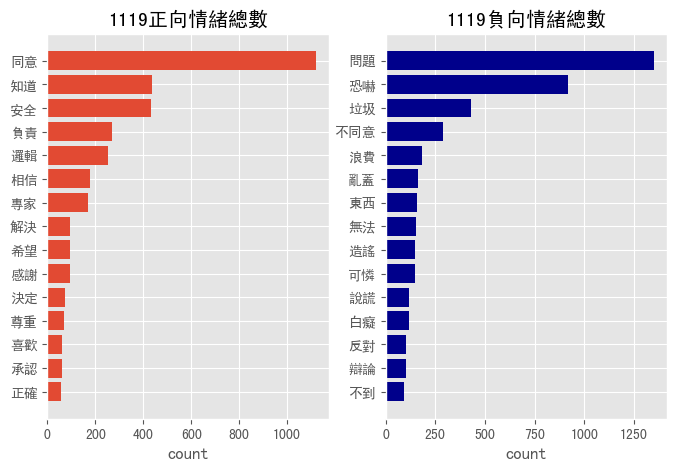

In [43]:
p_sum = sentiment_1119[sentiment_1119["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1119[sentiment_1119["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1119正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('1119負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 3.7 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [44]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments                                             artUrl  ntusd-negative  \
0           https://www.ptt.cc/bbs/Gossiping/M.1634533011....              15   
1           https://www.ptt.cc/bbs/Gossiping/M.1634552359....              18   
2           https://www.ptt.cc/bbs/Gossiping/M.1634553019....               7   
3           https://www.ptt.cc/bbs/Gossiping/M.1634553351....              18   
4           https://www.ptt.cc/bbs/Gossiping/M.1634556691....              17   

sentiments  ntusd-positive  
0                       15  
1                       15  
2                        3  
3                        6  
4                       22

In [45]:
article_type['type'] = article_type.apply(lambda x: 'ntusd-positive' if x['ntusd-positive'] > x['ntusd-negative'] else 'ntusd-negative',axis=1)
article_type.groupby('type', as_index=False).size()

type  size
0  ntusd-negative  2180
1  ntusd-positive   710

- 這邊可以看出 負面情緒文章為 2179 正面只有 711
- 可以看出公投的文章以及留言大多都為負面

### 正負情緒文章數量統計圖

In [46]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
article_type_date

artDate            type  size
0   2021/10/18  ntusd-negative    11
1   2021/10/18  ntusd-positive     2
2   2021/10/19  ntusd-negative     4
3   2021/10/19  ntusd-positive     1
4   2021/10/20  ntusd-negative     5
..         ...             ...   ...
71  2021/11/25  ntusd-positive    30
72  2021/11/26  ntusd-negative    61
73  2021/11/26  ntusd-positive    29
74  2021/11/27  ntusd-negative    43
75  2021/11/27  ntusd-positive    15

[76 rows x 3 columns]

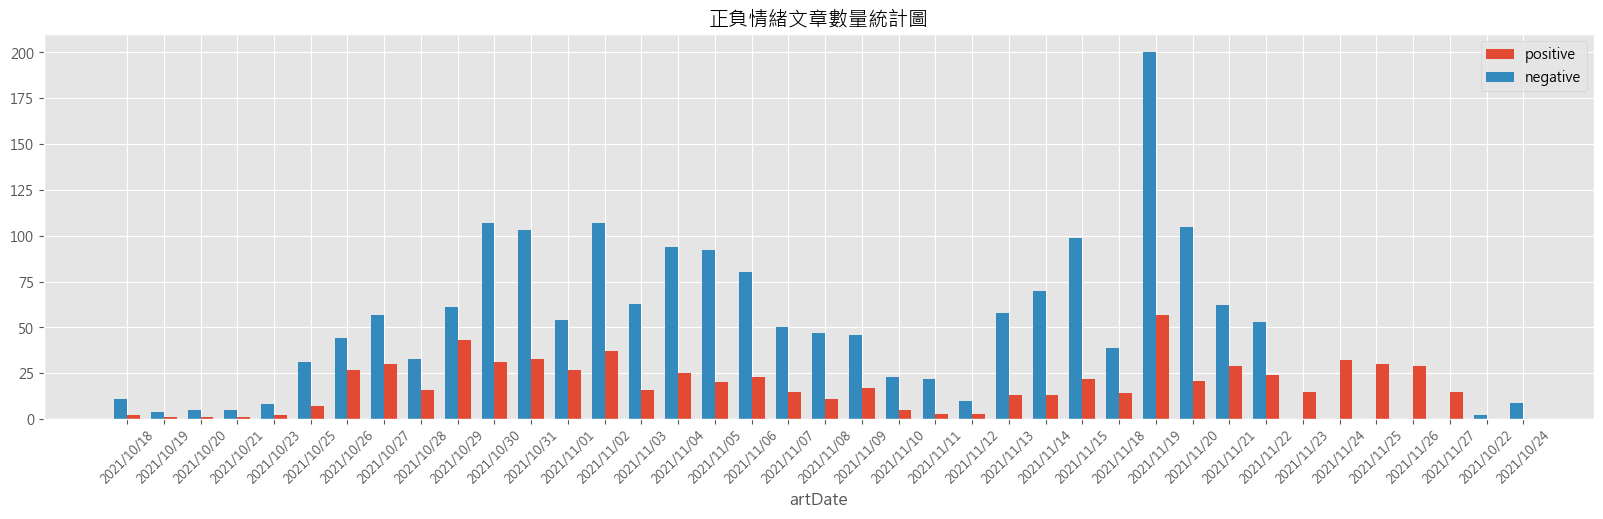

In [47]:
ap = article_type_date[(article_type_date["type"]=="ntusd-positive")&(article_type_date["artDate"]>="2021/10/18")&(article_type_date["artDate"]<="2021/11/27")]
an = article_type_date[(article_type_date["type"]=="ntusd-negative")&(article_type_date["artDate"]>="2021/10/18")&(article_type_date["artDate"]<="2021/11/22")]

plt.figure(figsize=(20,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")

plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')

plt.show()

- 可以看到負面文章較多。

### 3.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併。 

In [48]:
positive_article = article_type[article_type["type"]=="ntusd-positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="ntusd-negative"].merge(data, how = 'left', on = 'artUrl')

### 情緒關鍵字:負面情緒文章

In [49]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

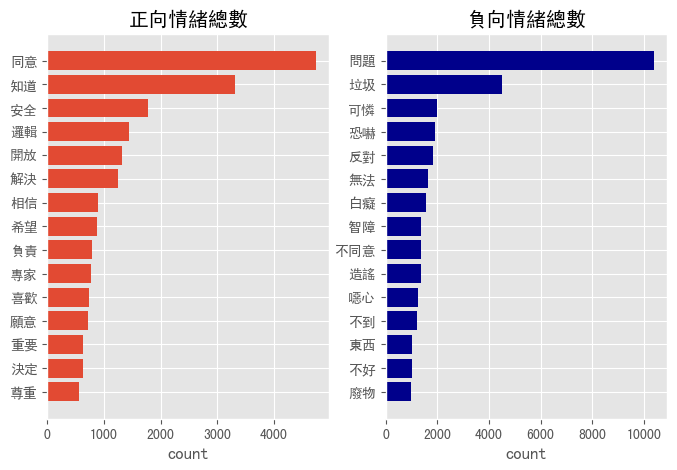

In [50]:
p_sum = negative_article[negative_article["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [51]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

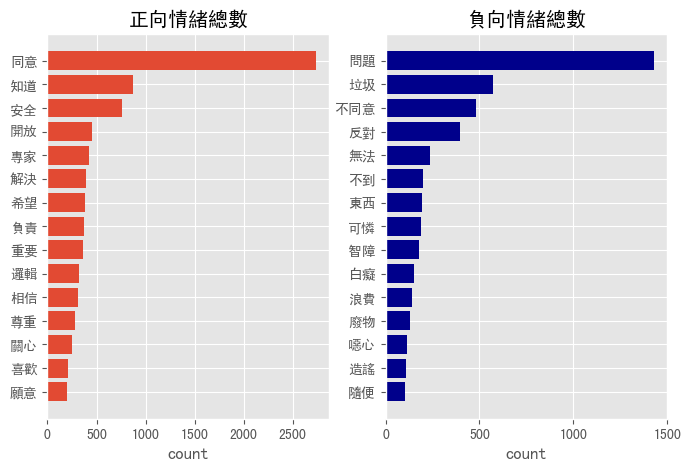

In [52]:
p_sum = positive_article[positive_article["sentiments"]=="ntusd-positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="ntusd-negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 3.9與東森新聞比較
看看不同的社群媒體對於同一個事件的情緒是否有差異。

In [53]:
news = pd.read_csv('./raw_data/1218公投案_新聞_articleMetaData.csv', encoding='UTF-8')

In [54]:
print(f"共有 {news.shape[0]} 篇東森新聞文章")
news.head()

共有 105 篇東森新聞文章


artTitle     artDate   artTime  \
0   政院拍板公投不在籍投票專法 最快2023年上路｜東森新聞  2021/09/30  00:00:00   
1      中台灣謝票！ 朱立倫赴雲林、江啟臣回台中｜東森新聞  2021/10/01  00:00:00   
2   政院推公投「不在籍投票」 藍委：應納入海外國人｜東森新聞  2021/10/01  00:00:00   
3  朱立倫力挺「刪Q」、「罷昶」 傳8月已發不出薪水｜東森新聞  2021/10/01  00:00:00   
4     嗆「蔡英文說聽不到可以翻桌」藍委翻倒備詢台｜東森新聞  2021/10/01  00:00:00   

                                        artUrl  \
0  https://news.ebc.net.tw/news/article/280668   
1  https://news.ebc.net.tw/news/article/280761   
2  https://news.ebc.net.tw/news/article/280770   
3  https://news.ebc.net.tw/news/article/280829   
4  https://news.ebc.net.tw/news/article/280870   

                                            sentence  
0  行政院院會今（30日）拍板通過中選會所提「全國性公民投票不在籍投票法草案」，開放民眾事先申請...  
1  國民黨主席選舉落幕，江啟臣與朱立倫將在10月5日提前交接，不過卻傳出，江啟臣是在推卸罷免和公...  
2  不在籍投票吵了很多年，行政院終於推出「公投不在籍投票」草案，也就是開放民眾事先申請「異地跨縣...  
3  國民黨主席競爭激烈，但誰當主席籌款都是燙手山芋。根據各報釋出的消息，前台東縣長黃健庭將接受朱...  
4  國民黨立委一早霸占備詢台杯葛議事，要求行政院長蘇貞昌和立法院長游錫堃道歉。立法院長游錫堃出面...

In [55]:
news['word'] = news.sentence.apply(clean) # 使用先前定義的斷詞與清除停用字function

In [56]:
news['word'] = news.word.apply(getToken)

In [57]:
DToken = news.explode('word') # 展開斷詞結果

In [58]:
news.head()

artTitle     artDate   artTime  \
0   政院拍板公投不在籍投票專法 最快2023年上路｜東森新聞  2021/09/30  00:00:00   
1      中台灣謝票！ 朱立倫赴雲林、江啟臣回台中｜東森新聞  2021/10/01  00:00:00   
2   政院推公投「不在籍投票」 藍委：應納入海外國人｜東森新聞  2021/10/01  00:00:00   
3  朱立倫力挺「刪Q」、「罷昶」 傳8月已發不出薪水｜東森新聞  2021/10/01  00:00:00   
4     嗆「蔡英文說聽不到可以翻桌」藍委翻倒備詢台｜東森新聞  2021/10/01  00:00:00   

                                        artUrl  \
0  https://news.ebc.net.tw/news/article/280668   
1  https://news.ebc.net.tw/news/article/280761   
2  https://news.ebc.net.tw/news/article/280770   
3  https://news.ebc.net.tw/news/article/280829   
4  https://news.ebc.net.tw/news/article/280870   

                                            sentence  \
0  行政院院會今（30日）拍板通過中選會所提「全國性公民投票不在籍投票法草案」，開放民眾事先申請...   
1  國民黨主席選舉落幕，江啟臣與朱立倫將在10月5日提前交接，不過卻傳出，江啟臣是在推卸罷免和公...   
2  不在籍投票吵了很多年，行政院終於推出「公投不在籍投票」草案，也就是開放民眾事先申請「異地跨縣...   
3  國民黨主席競爭激烈，但誰當主席籌款都是燙手山芋。根據各報釋出的消息，前台東縣長黃健庭將接受朱...   
4  國民黨立委一早霸占備詢台杯葛議事，要求行政院長蘇貞昌和立法院長游錫堃道歉。立法院長游錫堃出面...   

                                                word  
0  [行政院, 院會, 30, 拍板, 中選會, 所提, 全國性, 公民投票, 在籍, 投票, ...  
1  [國民黨, 主席, 選舉, 落幕, 江啟, 朱立倫, 將在, 10, 提前, 交接, 傳出,...  
2  [在籍, 投票, 很多年, 行政院, 終於, 推出, 公投, 在籍, 投票, 草案, 開放,...  
3  [國民黨, 主席, 競爭, 激烈, 誰當, 主席, 籌款, 燙手山芋, 各報, 釋出, 消息...  
4  [國民黨, 立委, 一早, 霸占, 備詢, 杯葛, 議事, 要求, 行政院長, 蘇貞昌, 立...

In [59]:
DToken["source"] = "東森新聞" # 設定新欄位source
DToken['artDate'] = pd.to_datetime(DToken['artDate'], format="%Y/%m/%d")

PToken = data
PToken["source"] = "PTT" # 設定新欄位source

In [60]:
news_senti_sum = (DToken.filter(["artDate","artUrl","word","source"])
                   .merge(df_liwc, on='word')
                   .groupby(['artDate', 'sentiments'], as_index=False)
                   .size()
                   .query('artDate >= "2021/10/19"'))


In [61]:
PTT_senti_sum = (PToken
                 .merge(df_liwc, on='word')
                 .groupby(['artDate', 'sentiments'], as_index=False)
                 .size()
                 .query('artDate >= "2021/10/19"'))

### ptt、東森新聞情緒分數比較

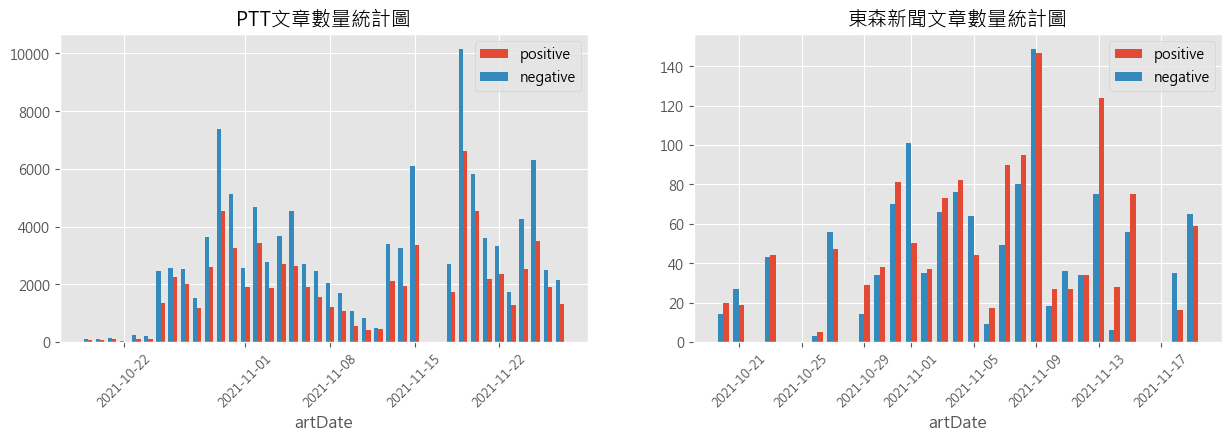

In [62]:
PTT_ap = PTT_senti_sum[PTT_senti_sum["sentiments"]=="ntusd-positive"]
PTT_an = PTT_senti_sum[PTT_senti_sum["sentiments"]=="ntusd-negative"]
news_ap = news_senti_sum[news_senti_sum["sentiments"]=="ntusd-positive"]
news_an = news_senti_sum[news_senti_sum["sentiments"]=="ntusd-negative"]

plt.figure(figsize=(15,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('PTT文章數量統計圖')
plt.xlabel('artDate')
plt.bar(PTT_ap['artDate'],PTT_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(PTT_an['artDate'],PTT_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')


plt.subplot(122)
plt.title('東森新聞文章數量統計圖')
plt.xlabel('artDate')
plt.bar(news_ap['artDate'],news_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(news_an['artDate'],news_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

* 這邊兩邊的數量scale不同，PTT文章還是比東森新聞的文章來得更多，PTT如同剛剛說的負面居多，東森則不一定有時負面多有時正面多

## 4. CKIP 標註

### 4.1 CKIP安裝

In [63]:
data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /home/zackary/Social/mid_project/final/data.zip
100%|██████████| 1.88G/1.88G [03:03<00:00, 10.2MB/s]


In [64]:
# To use CPU:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

### 4.2 將抓取結果用coreNLP進行處理

(1) 定義文字清理的相關function

In [65]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [66]:
# 自定義辭典
with open('./dict/政治.txt' , encoding = 'UTF-8') as f:
    lines = f.read().splitlines()

dict_harry = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_harry)
#print(dictionary2)

In [67]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary  
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['artUrl'],sentence])            
            temp_tokens = get_pos(row['artUrl'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['artUrl'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['artUrl','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['artUrl','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['artUrl','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [68]:
#pos_table, entity_table, sentence_table = get_nlp_result(MetaData)

In [69]:
#pos_table.head(5) # word pos 列表

In [70]:
#entity_table.head(5) # word entity 列表

In [71]:
# 檢查筆數正不正確
#print(f"total posts numbers: {len(pos_table['artUrl'].unique())}") #
#print(f"posts have NER: {len(entity_table['artUrl'].unique())}") # 

In [72]:
# 將推特文章存成csv
#pos_table.to_csv(r'./raw_data/pos_table_referendum.csv', index = False)
#entity_table.to_csv(r'./raw_data/entity_table_referendum.csv', index = False)
#sentence_table.to_csv(r'./raw_data/sentence_table_referendum.csv', index = False)

# 3.3 探索分析 - NER

In [73]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./raw_data/pos_table_referendum.csv") 
entity_table = pd.read_csv("./raw_data/entity_table_referendum.csv") 
sentence_table = pd.read_csv("./raw_data/sentence_table_referendum.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類

In [74]:
entity_table['ner'].unique()

array(['GPE', 'PERSON', 'NORP', 'ORG', 'LOC', 'DATE', 'ORDINAL', 'FAC',
       'MONEY', 'CARDINAL', 'WORK_OF_ART', 'TIME', 'LAW', 'PRODUCT',
       'LANGUAGE', 'EVENT', 'QUANTITY', 'PERCENT'], dtype=object)

In [75]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

ner  count
4        GPE   8039
13    PERSON   7806
11       ORG   6895
3        FAC   3821
0   CARDINAL   3664
1       DATE   2975
9       NORP   1264
10   ORDINAL    564
7        LOC    469
16      TIME    342
2      EVENT    183
15  QUANTITY    153

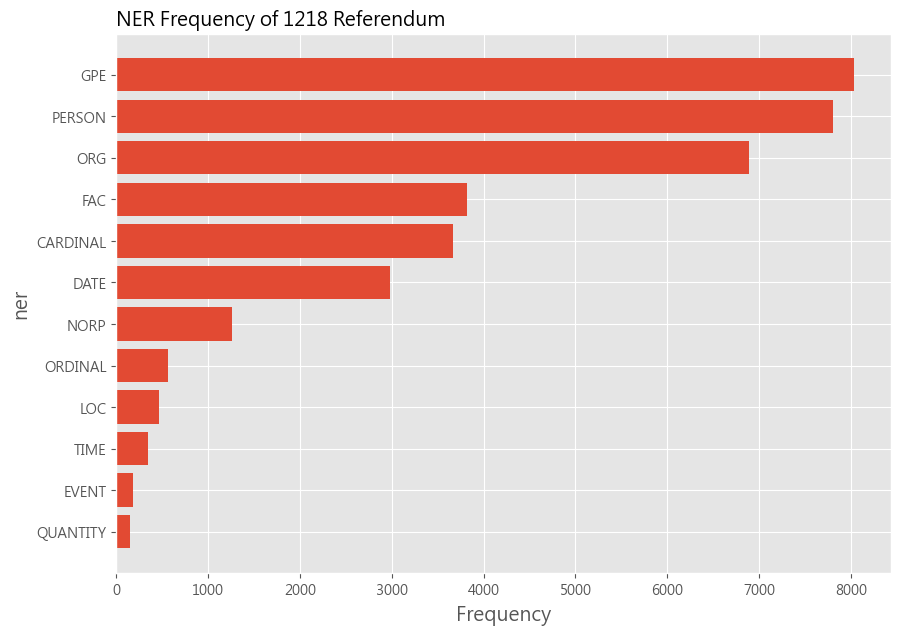

In [76]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of 1218 Referendum',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

透過NER來看1218公投，可以看出GPE、PERSON、ORG為前三個
因此分別來探討

### 涉及到的人名(PERSON)

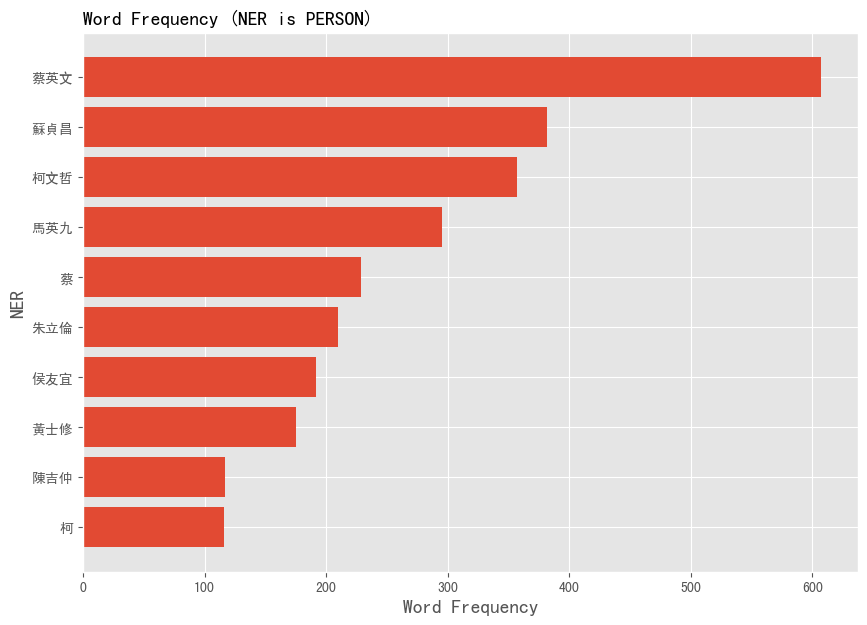

In [77]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的貼文內容

In [78]:
keyword_list = ['蔡英文','蘇貞昌']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

蔡英文 蘇貞昌：791篇相關貼文


artUrl  \
3    https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
4    https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
5    https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
6    https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
139  https://www.ptt.cc/bbs/Gossiping/M.1634643095....   
140  https://www.ptt.cc/bbs/Gossiping/M.1634643095....   
169  https://www.ptt.cc/bbs/Gossiping/M.1634689134....   
170  https://www.ptt.cc/bbs/Gossiping/M.1634689134....   
176  https://www.ptt.cc/bbs/Gossiping/M.1634729005....   
220  https://www.ptt.cc/bbs/Gossiping/M.1634780214....   

                                              sentence  
3    誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...  
4    行政院長蘇貞昌排第一衛福部長陳時中第二，而排名第三的農委會主委陳吉仲今日被問此事表示，能跟他...  
5                       這份內閣改組該撤換誰調查顯示，蘇貞昌以居冠，其次陳時中陳吉仲  
6    陳吉仲之前因萊豬走私貓和大陸暫停進口台灣水果等議題，在網路溫度計月公布數字創下高聲量，而根據...  
139  行政院長蘇貞昌不滿意度漸高，桃園市長鄭文燦被認為是下屆閣揆，王世堅說，他不敢再臆測人選，以前...  
140  蘇貞昌昨天到苗栗頭份國中管要栽什麼樹種，近期更頻頻與立委互罵，被認為應該著力在五倍券疫苗等大...  
169  台灣是投票率超高，年輕人回鄉投票，結果投給無恥蔡英文，有名導演有名藝人大多都力挺民進黨，力挺...  
170                 改革也許會很難，但郭董至少會聽人民聲音，不像噁心蔡英文只會裝作看不見  
176                                     馬英九的拒馬可沒有蔡英文的大  
220                       批蔡英文是威權國民黨的既得利益者羅智強有什麼資格出來說嘴

### 涉及到的組織(ORG)

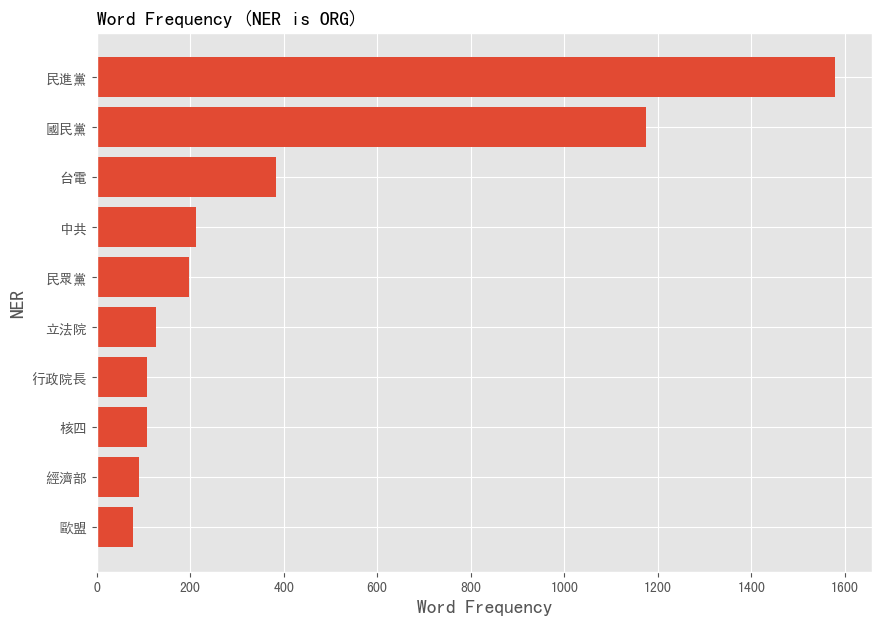

In [79]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 地理、政治(GPE) 

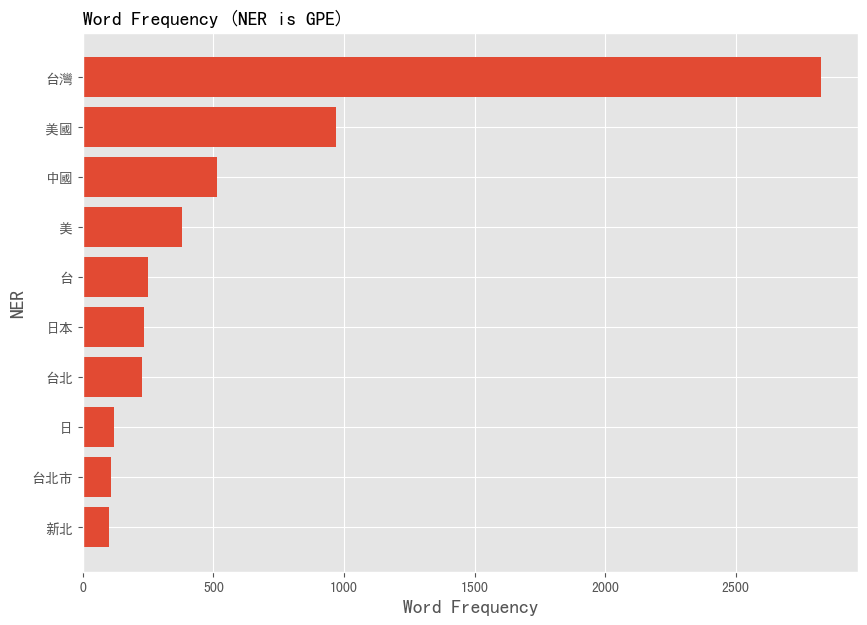

In [80]:
# 篩選ner為名詞的資料
l_noun = ["GPE"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is GPE)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [81]:
keyword_list = ['台灣','美國','中國']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(5)

台灣 美國 中國：3126篇相關貼文


artUrl  \
0   https://www.ptt.cc/bbs/Gossiping/M.1634527215....   
6   https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
10  https://www.ptt.cc/bbs/Gossiping/M.1634553351....   
22  https://www.ptt.cc/bbs/Gossiping/M.1634556797....   
23  https://www.ptt.cc/bbs/Gossiping/M.1634556797....   

                                             sentence  
0   乾脆各縣市都合併起來，建一個中華台北，國際承認中華台北，中華台北有參加公投民意通過品質掛保證...  
6   陳吉仲之前因萊豬走私貓和大陸暫停進口台灣水果等議題，在網路溫度計月公布數字創下高聲量，而根據...  
10  首先有個人會餓死但如果抵擋不住誘惑的話也許還會活著然後台灣能減少碳排放讓世界看見台灣無人島塞...  
22  再生能源這款偽善不穩定電力又逢未來世界氣候只會往極端發展的趨勢法國總統及挪威等歐陸多國已經宣...  
23                                       支持台灣興建核電請推文啦

## 3.4 探索分析 - POS

### POS 種類分析
查看辨識出哪幾種POS

In [82]:
pos_table['pos'].unique()

array(['VH', 'Nes', 'Nc', 'D', 'VC', 'Di', 'COMMACATEGORY', 'Neu', 'Nf',
       'VE', 'V_2', 'VA', 'Na', 'Nb', 'SHI', 'P', 'VHC', 'VG', 'VF', 'Da',
       'Neqa', 'VJ', 'DE', 'Nh', 'T', 'Cbb', 'Nv', 'VK', 'VCL', 'Caa',
       'Nd', 'Dfa', 'Nep', 'VB', 'Cab', 'Ncd', 'VL', 'VAC', 'Cba', 'A',
       'Ng', 'VD', 'I', 'FW', 'Dfb', 'Dk', 'VI', 'DM', 'Neqb',
       'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'ETCCATEGORY',
       'SEMICOLONCATEGORY', 'DASHCATEGORY', 'COLONCATEGORY'], dtype=object)

In [83]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

pos  count
17   Na  87409
5     D  60385
38   VC  37493
44   VH  25711
19   Nc  24529
7    DE  17849
41   VE  16020
31    P  15978
35   VA  14683
18   Nb  13015
29   Nh  12510
33  SHI  10928

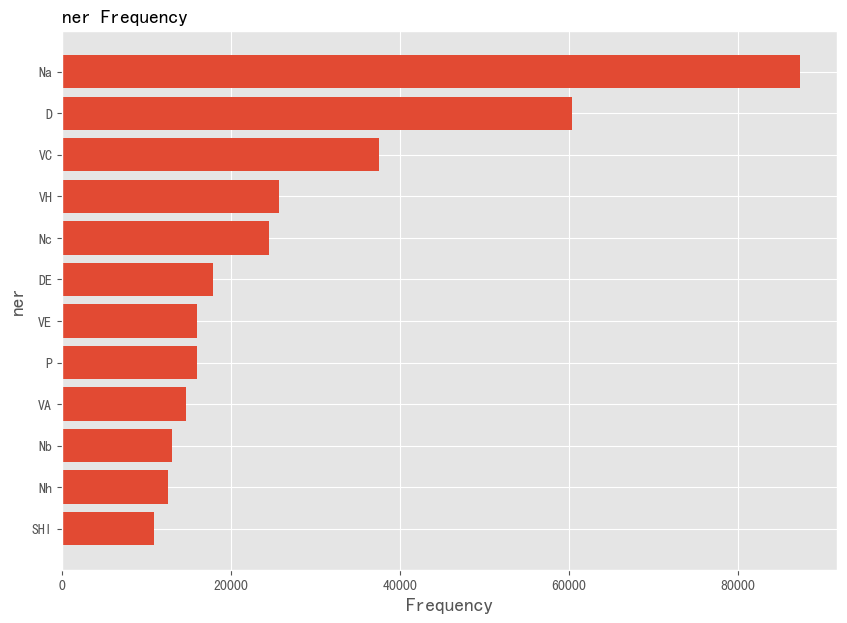

In [84]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

In [85]:
# 篩選pos為名詞的資料
l_noun = ["Na"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

word  count
0    人   2595
1   問題   1531
2   萊豬   1370
3   政府   1288
4   新聞   1143
5    豬   1103
6    月    682
7   人民    675
8    核    665
9   總統    652

In [86]:
# 寫法二
noun_count = noun[['word']].groupby(['word'])['word'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(15)
noun_count.head(10)

word  count
300     人   2595
1646   問題   1531
7264   萊豬   1370
3822   政府   1288
3995   新聞   1143
7867    豬   1103
4204    月    682
337    人民    675
4336    核    665
6691   總統    652

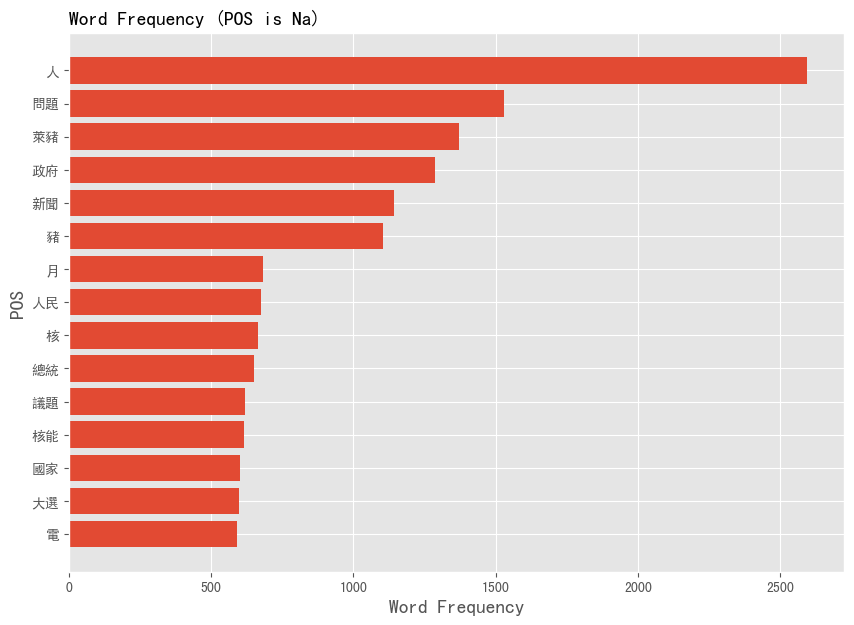

In [87]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Na)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 副詞(D)

In [88]:
l_verb = ["D"] 
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'] \
                                 .count() \
                                 .reset_index(name='count') \
                                 .sort_values(['count'], ascending=False) \
                                 .head(15)
verb_count

word  count
216   可以   1394
570   真的    765
394   應該    684
380   怎麼    660
60    不會    654
737   還是    619
73    不要    604
65    不能    575
497   沒有    563
330   已經    559
478   根本    477
525   然後    466
13    一定    407
508  為什麼    386
144   其實    385

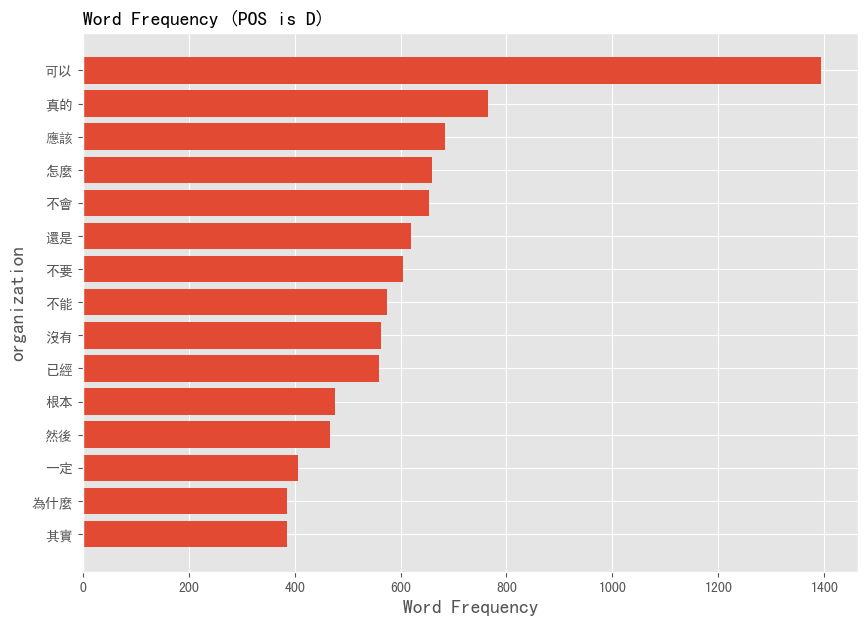

In [89]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is D)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [90]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['可以','真的','應該']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關貼文")
select.head(10)

可以 真的 應該：2259篇相關貼文


artUrl  \
7   https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
8   https://www.ptt.cc/bbs/Gossiping/M.1634552359....   
24  https://www.ptt.cc/bbs/Gossiping/M.1634556797....   
27  https://www.ptt.cc/bbs/Gossiping/M.1634564126....   
29  https://www.ptt.cc/bbs/Gossiping/M.1634564590....   
37  https://www.ptt.cc/bbs/Gossiping/M.1634569886....   
40  https://www.ptt.cc/bbs/Gossiping/M.1634572132....   
42  https://www.ptt.cc/bbs/Gossiping/M.1634575761....   
47  https://www.ptt.cc/bbs/Gossiping/M.1634609719....   
55  https://www.ptt.cc/bbs/Gossiping/M.1634618084....   

                                             sentence  
7   現在又有雜誌調查內閣改組應先換下排第名的陳吉仲，對此，他本人今回應，可以跟他們排在一起是我的...  
8   核四花了一堆錢做出來的拼裝核電廠目前檯面上的政客都沒人敢開目前核一已經除役核二再兩年也要進去...  
24  勿因秋冬就選擇遺忘明年酷暑依然會到來燃料棒走海運應該已抵達美國了呦核全面翻新更安全且發電效率...  
27  好慘喔我看原文底下推文風向根本一面倒八卦網友紛紛表示冷血議員又在裝可憐你可以跟著眾側翼洗韓導...  
29  我是最強的~~~我有話說本來要用爆卦，但上次用爆卦就被停權一個月油價真的是今年漲翻天了目前看...  
37  另外還有並非受害者的防疫女神許書華醫師，也留言為黃捷打氣，支持抑制歪風，八卦板鄉民對於黃捷受...  
40  這其實也沒什麼好吵好民調的，民進黨真的想要這幾個縣市併，那就去辦公投連署讓居民投票，不要自己...  
42  綠畜黨緊張柯訪美柯也大方說出事實被美國了解這是所有有望贏得總統大選人的必經之路綠畜黨絕對很了...  
47  告訴你們我早就知道結局查無不法謝謝指教這調查就是用來演戲騙騙智障讓他們相信綠畜黨人沒貪污而已...  
55  整篇還真的證明那幾個粉專還真的沒領錢用愛發電建議卡神以這個為範例跟檢察官說琪姊真的是單純好心...

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [91]:
sentence_table = pd.read_csv("./raw_data/sentence_table_referendum.csv") #匯資料
tweets_df = MetaData.copy() #匯資料
#移除PTT貼新聞時會出現的格式用字
tweets_df['sentence'] = tweets_df.sentence.apply(lambda x: re.sub('(新聞|網址|新聞來源|媒體來源|記者署名|完整新聞|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
tweets_df['sentence'] = tweets_df.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
#只留下中文字
tweets_df['sentence'] =tweets_df.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
sentiment_date = pd.merge(sentence_table,tweets_df[['artUrl','artDate','artCat']],on='artUrl',how='left')
sentiment_date.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634527215....   
1  https://www.ptt.cc/bbs/Gossiping/M.1634530660....   
2  https://www.ptt.cc/bbs/Gossiping/M.1634530660....   

                                            sentence artDate artCat  
0  乾脆各縣市都合併起來，建一個中華台北，國際承認中華台北，中華台北有參加公投民意通過品質掛保證...     NaN    NaN  
1  其實大家重點都錯了要併新北市的石門金山萬里瑞芳貢寮雙溪平溪啊有問過當地居民意見嗎基隆就算變直...     NaN    NaN  
2                                               他萬的長     NaN    NaN

In [92]:
from snownlp import SnowNLP

In [93]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(5)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634527215....   
1  https://www.ptt.cc/bbs/Gossiping/M.1634530660....   
2  https://www.ptt.cc/bbs/Gossiping/M.1634530660....   
3  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   
4  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   

                                            sentence     artDate     artCat  \
0  乾脆各縣市都合併起來，建一個中華台北，國際承認中華台北，中華台北有參加公投民意通過品質掛保證...         NaN        NaN   
1  其實大家重點都錯了要併新北市的石門金山萬里瑞芳貢寮雙溪平溪啊有問過當地居民意見嗎基隆就算變直...         NaN        NaN   
2                                               他萬的長         NaN        NaN   
3  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...  2021/10/18  Gossiping   
4  行政院長蘇貞昌排第一衛福部長陳時中第二，而排名第三的農委會主委陳吉仲今日被問此事表示，能跟他...  2021/10/18  Gossiping   

   sentimentValue  
0        0.012333  
1        0.000004  
2        0.473767  
3        0.000117  
4        0.000156

In [94]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe() # 2145句話

count    14579.000000
mean         0.326266
std          0.360862
min          0.000000
25%          0.004585
50%          0.148457
75%          0.611782
max          1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

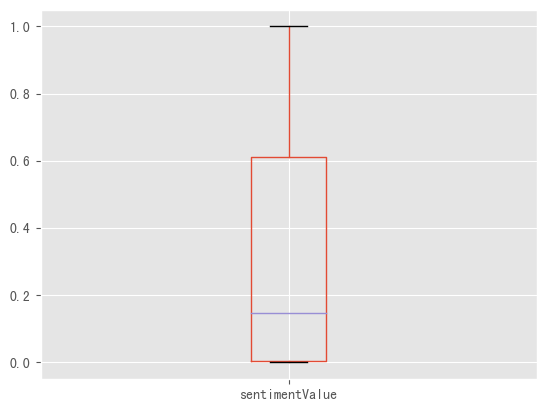

In [95]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

- 從這個boxplot可以明顯看出鄉民對於公投這個主題罵聲連連

In [96]:
sentiment_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.date
sentiment_count = sentiment_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2021-10-18        0.176914
1   2021-10-19        0.417996
2   2021-10-20        0.322169
3   2021-10-21        0.433308
4   2021-10-22        0.321506
5   2021-10-23        0.364118
6   2021-10-24        0.392833
7   2021-10-25        0.310148
8   2021-10-26        0.290609
9   2021-10-27        0.316271
10  2021-10-28        0.287830
11  2021-10-29        0.374549
12  2021-10-30        0.309814
13  2021-10-31        0.303743
14  2021-11-01        0.329801
15  2021-11-02        0.344389
16  2021-11-03        0.344460
17  2021-11-04        0.305878
18  2021-11-05        0.359636
19  2021-11-06        0.366162
20  2021-11-07        0.319743
21  2021-11-08        0.344040
22  2021-11-09        0.374260
23  2021-11-10        0.339722
24  2021-11-11        0.363912
25  2021-11-12        0.204628
26  2021-11-13        0.308859
27  2021-11-14        0.321960
28  2021-11-15        0.316716
29  2021-11-18        0.288406
30  2021-11-19        0.306778
31  2021-11-20        0.292371
32  2021-11-21        0.340742
33  2021-11-22        0.338999
34  2021-11-23        0.387562
35  2021-11-24        0.342887
36  2021-11-25        0.336748
37  2021-11-26        0.307646
38  2021-11-27        0.317237

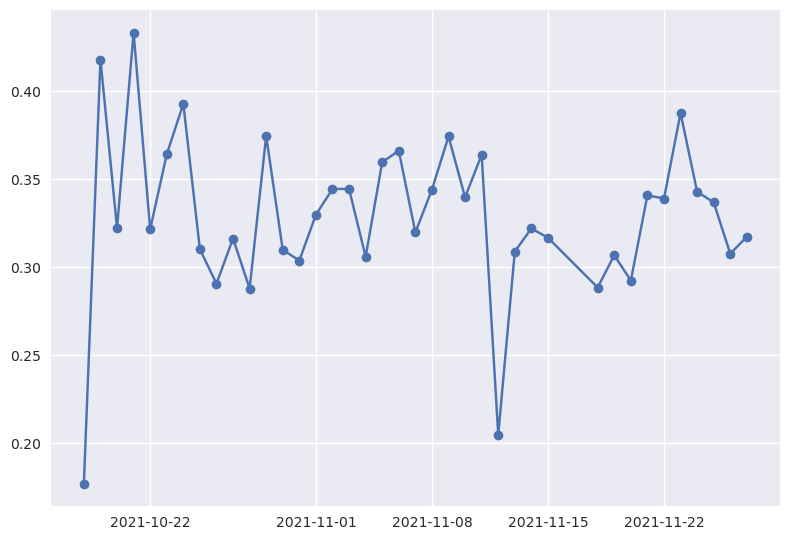

In [97]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.show()

## 不同"版"的情緒時間趨勢

In [98]:
# 篩出八卦和政黑的版
sentiment_date = sentiment_date[sentiment_date['artCat'].isin(['Gossiping', 'HatePolitics'])]
# 算每天的情緒
source_count = sentiment_date.groupby(['artDate','artCat'])['sentimentValue'].mean().reset_index()
source_count.head(5)

artDate        artCat  sentimentValue
0  2021-10-18     Gossiping        0.165316
1  2021-10-18  HatePolitics        0.571231
2  2021-10-19     Gossiping        0.413208
3  2021-10-19  HatePolitics        0.571231
4  2021-10-20     Gossiping        0.364575

In [99]:
# spread the column
source_pivot = source_count.pivot_table(index=['artDate'],columns='artCat',values='sentimentValue',fill_value=0).reset_index()
source_pivot

artCat     artDate  Gossiping  HatePolitics
0       2021-10-18   0.165316      0.571231
1       2021-10-19   0.413208      0.571231
2       2021-10-20   0.364575      0.249138
3       2021-10-21   0.433308      0.000000
4       2021-10-22   0.000000      0.321506
5       2021-10-23   0.475267      0.141820
6       2021-10-24   0.469154      0.011228
7       2021-10-25   0.292241      0.387371
8       2021-10-26   0.258987      0.351169
9       2021-10-27   0.309672      0.327218
10      2021-10-28   0.295385      0.256010
11      2021-10-29   0.379108      0.353841
12      2021-10-30   0.318912      0.275301
13      2021-10-31   0.300777      0.310893
14      2021-11-01   0.321369      0.344394
15      2021-11-02   0.312638      0.463455
16      2021-11-03   0.330161      0.374591
17      2021-11-04   0.289130      0.359078
18      2021-11-05   0.367459      0.325631
19      2021-11-06   0.366742      0.364764
20      2021-11-07   0.311506      0.358300
21      2021-11-08   0.276229      0.436318
22      2021-11-09   0.378045      0.351732
23      2021-11-10   0.316984      0.390332
24      2021-11-11   0.340615      0.554949
25      2021-11-12   0.157832      0.215547
26      2021-11-13   0.305547      0.321976
27      2021-11-14   0.319156      0.329456
28      2021-11-15   0.314236      0.324875
29      2021-11-18   0.288601      0.285223
30      2021-11-19   0.294766      0.378954
31      2021-11-20   0.287587      0.311166
32      2021-11-21   0.332004      0.414292
33      2021-11-22   0.331429      0.373730
34      2021-11-23   0.404381      0.323942
35      2021-11-24   0.325540      0.420224
36      2021-11-25   0.336659      0.337185
37      2021-11-26   0.315128      0.256340
38      2021-11-27   0.317237      0.000000

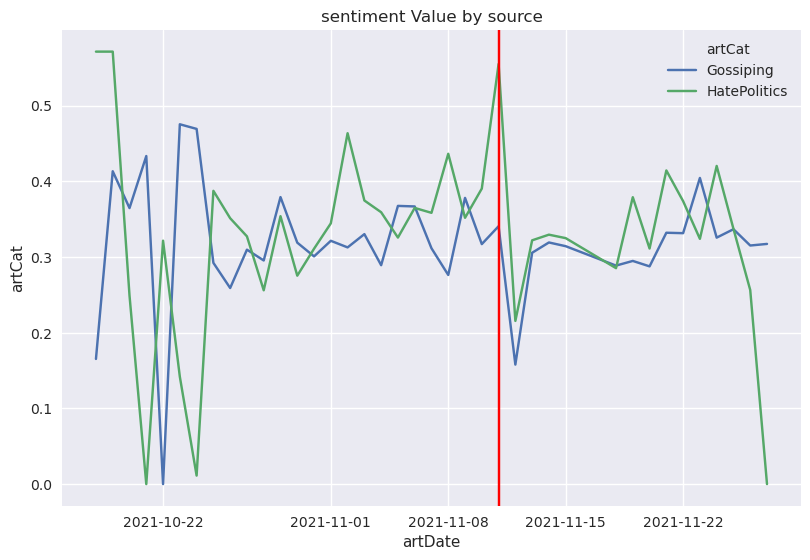

In [100]:
# 不同版情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="artDate", y=["Gossiping", "HatePolitics"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('artCat')
plt.title('sentiment Value by source')
#plt.axvline(x=datetime.strptime('2021-11-19', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-11-11', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-30', "%Y-%m-%d"), color="red", ls="-")
plt.show()

- 可以看出看兩個版，對於公投情緒分數都很低，這兩個版其實會留言的人都差不多，所以情緒分析不會差太多。

### 正面詞彙探索
從上圖中可以發現 11/11 的情緒特別高，因此我們從11/9~11/12中的正面句子挑出來看看他們都用甚麼詞，根據上面的盒狀圖我們可以發現，文中句子的情緒值大部分偏低，平均大概在0.3左右，臨界點取和平均一樣，選情緒值選0.3以上的句子。

In [101]:
# 篩時間區間
startdate = pd.to_datetime("2021-11-18").date()
enddate = pd.to_datetime("2021-11-20").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] >= 0.3]

# 看一下正面句子都在討論甚麼
filter_sentiment.head(5)

artUrl  \
7831  https://www.ptt.cc/bbs/Gossiping/M.1637251078....   
7837  https://www.ptt.cc/bbs/Gossiping/M.1637251182....   
7841  https://www.ptt.cc/bbs/Gossiping/M.1637251852....   
7842  https://www.ptt.cc/bbs/Gossiping/M.1637252414....   
7843  https://www.ptt.cc/bbs/Gossiping/M.1637252414....   

                                               sentence     artDate  \
7831               反正反核與擁核都對核四都沒信心，不如直接核四快速拆除，直接就地改建為核五  2021-11-18   
7837  我支持現在立刻直接調查核四弊案，而不是用反核阻止核四簡單說現在反核核四有弊案，因此要反核，不...  2021-11-18   
7841                                    我是只看到某黨的網軍越養越多啦  2021-11-18   
7842                                     這和某人今天講的不一樣耶理性  2021-11-18   
7843  美國延役一堆核機組都要用到年非唯一解以往每年編預算就是用於維護自然老化是不是在維護範圍內用你...  2021-11-18   

         artCat  sentimentValue  
7831  Gossiping        0.877021  
7837  Gossiping        1.000000  
7841  Gossiping        0.537593  
7842  Gossiping        0.486404  
7843  Gossiping        0.999999

In [102]:
# 把時間分數和之前斷詞的token table做 join
positive_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
positive_words = positive_words[['artUrl','sentimentValue','word']]
positive_words.head(5)

artUrl  sentimentValue word
0  https://www.ptt.cc/bbs/Gossiping/M.1637251078....        0.877021   反正
1  https://www.ptt.cc/bbs/Gossiping/M.1637251078....        0.877021   反核
2  https://www.ptt.cc/bbs/Gossiping/M.1637251078....        0.877021    與
3  https://www.ptt.cc/bbs/Gossiping/M.1637251078....        0.877021   擁核
4  https://www.ptt.cc/bbs/Gossiping/M.1637251078....        0.877021    都

In [103]:
# 篩選只有單個字元的結果
positive_words = positive_words[positive_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [104]:
# 自定停用字
with open('./dict/stopwords.txt', encoding = 'UTF-8') as f:
    stop_words = f.read().splitlines()

#print(stop_words)

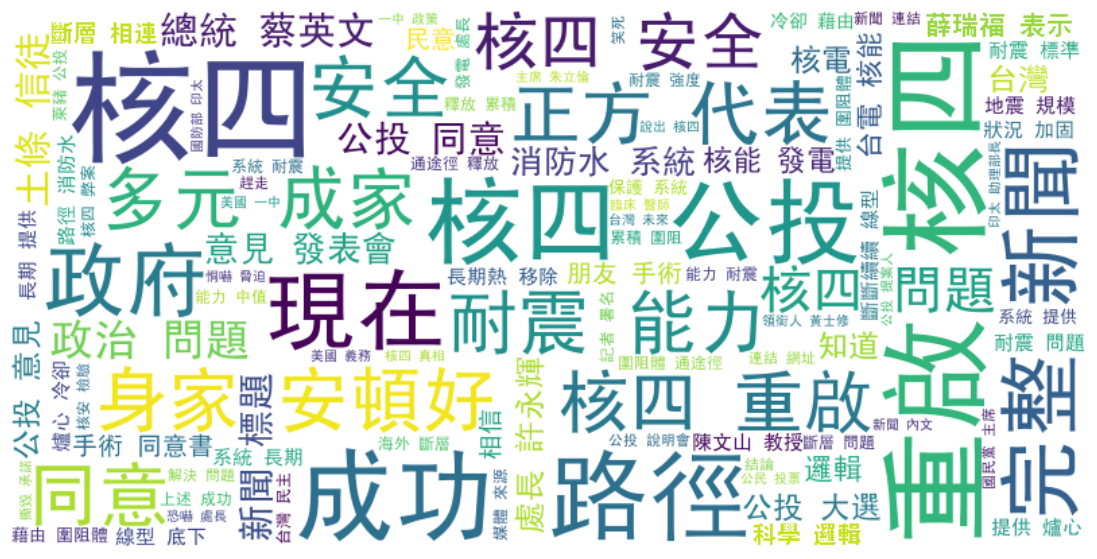

In [105]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
#stop_words_pos.extend(('哈利波特','魔法覺醒','緩緩','綻放','最近'))
#stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = '/home/zackary/Social/font/SimHei.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(positive_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

### 負面詞彙探索

In [106]:
# 篩時間區間
startdate = pd.to_datetime("2021-11-15").date()
enddate = pd.to_datetime("2021-11-21").date()
filter_sentiment = sentiment_date[sentiment_date.artDate.between(startdate, enddate)]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.3]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

artUrl  \
7359  https://www.ptt.cc/bbs/Gossiping/M.1636944334....   
7362  https://www.ptt.cc/bbs/Gossiping/M.1636945156....   
7365  https://www.ptt.cc/bbs/Gossiping/M.1636945156....   
7366  https://www.ptt.cc/bbs/Gossiping/M.1636945156....   
7368  https://www.ptt.cc/bbs/Gossiping/M.1636945657....   
7369  https://www.ptt.cc/bbs/Gossiping/M.1636945657....   
7370  https://www.ptt.cc/bbs/Gossiping/M.1636945659....   
7377  https://www.ptt.cc/bbs/Gossiping/M.1636949041....   
7378  https://www.ptt.cc/bbs/Gossiping/M.1636949041....   
7380  https://www.ptt.cc/bbs/Gossiping/M.1636949041....   

                                               sentence     artDate  \
7359  好油表示，以目前鑽探的資料來研判，這個斷層是安全的，核四就算在上面也沒問題，如果要更確認這個...  2021-11-15   
7362                                其實核四就不是科學問題，完全是政治問題  2021-11-15   
7365                                           但實際是做不到的  2021-11-15   
7366                                          這明明就是政治問題  2021-11-15   
7368                                      那可不可以把核二核三也停掉  2021-11-15   
7369          因為他們也在斷層帶上這樣應該就很安全了只是以後大家天乾物燥小心火燭晚上儘量不要開燈  2021-11-15   
7370                                 中央地質調查所的地質調查安全評估報告  2021-11-15   
7377  根據之前發生過的經驗來判斷中央地質調查所已經被中共滲透是中共同路人斷層觀測系統一定有中資系統...  2021-11-15   
7378                                    系統及報告密封年誰再提就是造謠  2021-11-15   
7380                   掌握提名權以徵招方式就沒有人敢造反都受過我的恩惠所以無法講真話了  2021-11-15   

         artCat  sentimentValue  
7359  Gossiping        0.008211  
7362  Gossiping        0.005250  
7365  Gossiping        0.183251  
7366  Gossiping        0.009265  
7368  Gossiping        0.108839  
7369  Gossiping        0.000952  
7370  Gossiping        0.005077  
7377  Gossiping        0.005967  
7378  Gossiping        0.292013  
7380  Gossiping        0.006847

In [107]:
# 把時間分數和之前斷詞的token table做 join
negative_words = pd.merge(filter_sentiment,pos_table,on='artUrl',how='left')
negative_words = negative_words[['artUrl','sentimentValue','word']]

In [108]:
# 篩選只有單個字元的結果
negative_words = negative_words[negative_words.apply(lambda x: len(x['word'])>1, axis=1)]

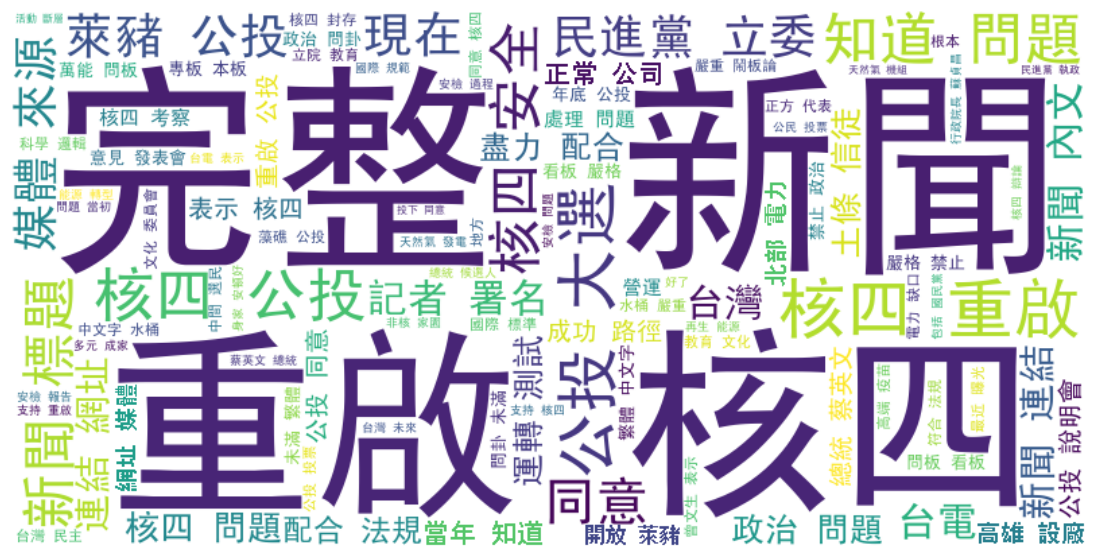

In [109]:
# 匯入自訂的 stop words
stop_words_neg = stop_words
#stop_words_neg.extend(('哈利波特','魔法覺醒','覺醒','玩'))
stop_words_neg = set(stop_words_neg)


# 設定中文字形
font_path = '/home/zackary/Social/font/SimHei.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_neg,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")\
                .generate(' '.join(negative_words['word']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

## 5. TF-IDF
- TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
### 5.1 計算每篇文章的詞數

In [110]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [111]:
# 將word欄位展開
data = data.explode('word')

In [112]:
data.head(3)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

  word  
0   下台  
0   僅次  
0  蘇貞昌

In [113]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

artUrl word  count
0       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   下台      1
1       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   主委      1
2       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今回      1
3       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今日      1
4       https://www.ptt.cc/bbs/Gossiping/M.1634533011....  以居冠      1
...                                                   ...  ...    ...
192176  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   垃圾      1
192177  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   惹台      1
192178  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   感覺      1
192179  https://www.ptt.cc/bbs/HatePolitics/M.16379452...  盡全力      1
192180  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   美國      1

[192181 rows x 3 columns]

In [114]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

artUrl  total
0     https://www.ptt.cc/bbs/Gossiping/M.1634533011....     96
1     https://www.ptt.cc/bbs/Gossiping/M.1634552359....     26
2     https://www.ptt.cc/bbs/Gossiping/M.1634553019....     18
3     https://www.ptt.cc/bbs/Gossiping/M.1634553351....     15
4     https://www.ptt.cc/bbs/Gossiping/M.1634556691....     34
...                                                 ...    ...
2887  https://www.ptt.cc/bbs/HatePolitics/M.16379257...    185
2888  https://www.ptt.cc/bbs/HatePolitics/M.16379377...    259
2889  https://www.ptt.cc/bbs/HatePolitics/M.16379389...     19
2890  https://www.ptt.cc/bbs/HatePolitics/M.16379432...    107
2891  https://www.ptt.cc/bbs/HatePolitics/M.16379452...     12

[2892 rows x 2 columns]

### 5.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [115]:
referendum_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
referendum_words

artUrl word  count  total
0       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   下台      1     96
1       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   主委      1     96
2       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今回      1     96
3       https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今日      1     96
4       https://www.ptt.cc/bbs/Gossiping/M.1634533011....  以居冠      1     96
...                                                   ...  ...    ...    ...
192176  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   垃圾      1     12
192177  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   惹台      1     12
192178  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   感覺      1     12
192179  https://www.ptt.cc/bbs/HatePolitics/M.16379452...  盡全力      1     12
192180  https://www.ptt.cc/bbs/HatePolitics/M.16379452...   美國      1     12

[192181 rows x 4 columns]

In [116]:
#計算tf
referendum_words_tf_idf = referendum_words.assign(tf = referendum_words.iloc[:,2]/referendum_words.iloc[:,3])

In [117]:
# 計算每個詞彙出現在幾篇文章中
idf_df = referendum_words.groupby(['word'],as_index=False).size()
referendum_words_tf_idf = referendum_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [118]:
#計算idf
referendum_words_tf_idf = referendum_words_tf_idf.assign(idf = referendum_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

referendum_words_tf_idf = referendum_words_tf_idf.drop(labels=['size'],axis=1)

In [119]:
#計算tf*idf
referendum_words_tf_idf = referendum_words_tf_idf.assign(tf_idf = referendum_words_tf_idf.iloc[:,4]*referendum_words_tf_idf.iloc[:,5])

In [120]:
referendum_words_tf_idf.head()

artUrl word  count  total  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   下台      1     96   
1  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   主委      1     96   
2  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今回      1     96   
3  https://www.ptt.cc/bbs/Gossiping/M.1634533011....   今日      1     96   
4  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  以居冠      1     96   

         tf       idf    tf_idf  
0  0.010417  1.683047  0.017532  
1  0.010417  1.440009  0.015000  
2  0.010417  3.461198  0.036054  
3  0.010417  1.396740  0.014549  
4  0.010417  3.461198  0.036054

### 5.3 檢視結果

In [121]:
# 選出每篇文章，tf-idf值最大的五個詞
group = referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [122]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/Gossiping/M.1634533011.A... 8     內閣  0.111794
                                                   7     光榮  0.089348
                                                   35    改組  0.089348
                                                   34    撤換  0.062168
                                                   14    吉仲  0.056500
https://www.ptt.cc/bbs/Gossiping/M.1634552359.A... 100   除役  0.138342
                                                   89   核二再  0.133123
                                                   98    目前  0.122086
                                                   84   因為電  0.121545
                                                   97    用台  0.114772
https://www.ptt.cc/bbs/Gossiping/M.1634553019.A... 109   糖衣  0.260806
                                                   108   毒藥  0.250786
                                                   115  香耶反  0.192289
                                                   103   執政  0.170839
                                                   102  反萊牛  0.121247

#### 計算整個文集中較常 tf-idf 值高的字

In [123]:
# 從每篇文章挑選出tf-idf最大的十個詞
(referendum_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

word  size
12067   美國    94
4352   國民黨    82
8976   核廢料    64
12860  蘇貞昌    54
12686   萊豬    53
9474   民進黨    52
8784   柯文哲    51
12850   藻礁    50
12803  蔡英文    49
4601   塔綠班    48

## 6 N-gram

### 6.1 Bigram

In [124]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [125]:
referendum_bigram = MetaData.copy()
referendum_bigram["word"] = referendum_bigram.sentence.apply(bigram_getToken)

In [126]:
referendum_bigram = referendum_bigram.explode('word')
referendum_bigram.head(3)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

      word  
0    下台 僅次  
0   僅次 蘇貞昌  
0  蘇貞昌 吉仲能

#### 統計最常出現的bigram組合

In [127]:
# 計算每個組合出現的次數
referendum_bigram_count = referendum_bigram.groupby(["word"],as_index=False).size()

In [128]:
# 清除包含英文或數字的bigram組合
wb_filter = list(referendum_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
referendum_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
23356      公投 大選   672
34110     反萊豬 公投   247
175370   重啟核四 公投   165
44114      四個 同意   146
150056  行政院長 蘇貞昌   140
137667    總統 蔡英文   138
24045     公投 說明會   133
97873      核四 安全   132
35955      台北 報導   129
148286     藻礁 公投   128

### 6.2 Trigram

In [129]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [130]:
referendum_trigram = MetaData.copy()
referendum_trigram["word"] = referendum_trigram.sentence.apply(trigram_getToken)
referendum_trigram = referendum_trigram.explode('word')
referendum_trigram.head(3)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

         word  
0   下台 僅次 蘇貞昌  
0  僅次 蘇貞昌 吉仲能  
0  蘇貞昌 吉仲能 光榮

#### 統計最常出現的trigram組合

In [131]:
# 計算每個組合出現的次數
referendum_trigram_count = referendum_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(referendum_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
referendum_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

word  size
58155    國民黨 主席 朱立倫    98
55209   四個不同意 台灣 有力    73
41177     反萊豬 公投 大選    69
43495     台北 市長 柯文哲    47
27432    公投 大選 珍愛藻礁    34
27832      公投 意見 發表    33
66547    夥伴 全面進步 協定    33
205129    農委會 主委 吉仲    33
69108   太平洋 夥伴 全面進步    33
107907    新北 市長 侯友宜    31

### 6.3. 建立Ngram預測模型

In [132]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [133]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [134]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [135]:
text = '公投'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 大選, probability: 0.157
next word: 說明會, probability: 0.0311
next word: 議題, probability: 0.0203
next word: 同意, probability: 0.0161
next word: 題目, probability: 0.0159


In [136]:
text = '核四'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 安全, probability: 0.0626
next word: 議題, probability: 0.0242
next word: 重啟, probability: 0.0242
next word: 問題, probability: 0.0237
next word: 封存, probability: 0.0194


In [137]:
text = '大選'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 公投, probability: 0.0539
next word: 珍愛藻礁, probability: 0.0417
next word: 重啟核四, probability: 0.0221
next word: 同意, probability: 0.0221
next word: 民進黨, probability: 0.0184


### 6.4 Bigram視覺化

In [138]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [139]:
referendum_bigram2 = MetaData.copy()
referendum_bigram2["word"] = referendum_bigram2.sentence.apply(bigram_getToken_dict)

In [140]:
referendum_bigram2 = referendum_bigram2.explode('word')
referendum_bigram2.head(3)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

      word  
0    下台 僅次  
0   僅次 蘇貞昌  
0  蘇貞昌 吉仲能

In [141]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('公投', '大選'), 672),
 (('反萊豬', '公投'), 247),
 (('重啟核四', '公投'), 165),
 (('四個', '同意'), 146),
 (('行政院長', '蘇貞昌'), 140)]

In [142]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [143]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.1 for w in  G.edges(data=True)]

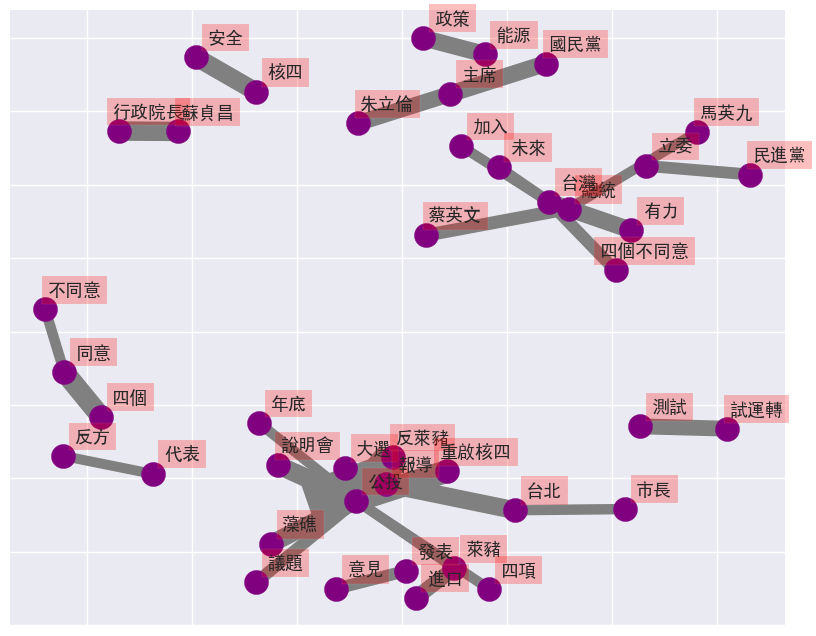

In [144]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示    
plt.show()

- 大概分為三個區域

## 7. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [145]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [146]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [147]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [148]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [149]:
bigram_df

word word2    n       cor
0      公投    大選  672  0.477547
1     反萊豬    公投  247  0.269450
2    重啟核四    公投  165  0.280533
3      四個    同意  146  0.353135
4    行政院長   蘇貞昌  140  0.727887
..    ...   ...  ...       ...
495    九二    共識   17  0.290951
496    台灣    豬農   17  0.067888
497    清楚    標示   17  0.201354
498    北部    供電   17  0.174159
499    美豬    等於   17  0.187984

[490 rows x 4 columns]

### 7.1 和 公投,  台灣 相關性最高的 15 個詞彙

In [150]:
c_sum = bigram_df[(bigram_df["word"]=="公投")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="台灣")].sort_values(by=['cor'], ascending = False).head(15)

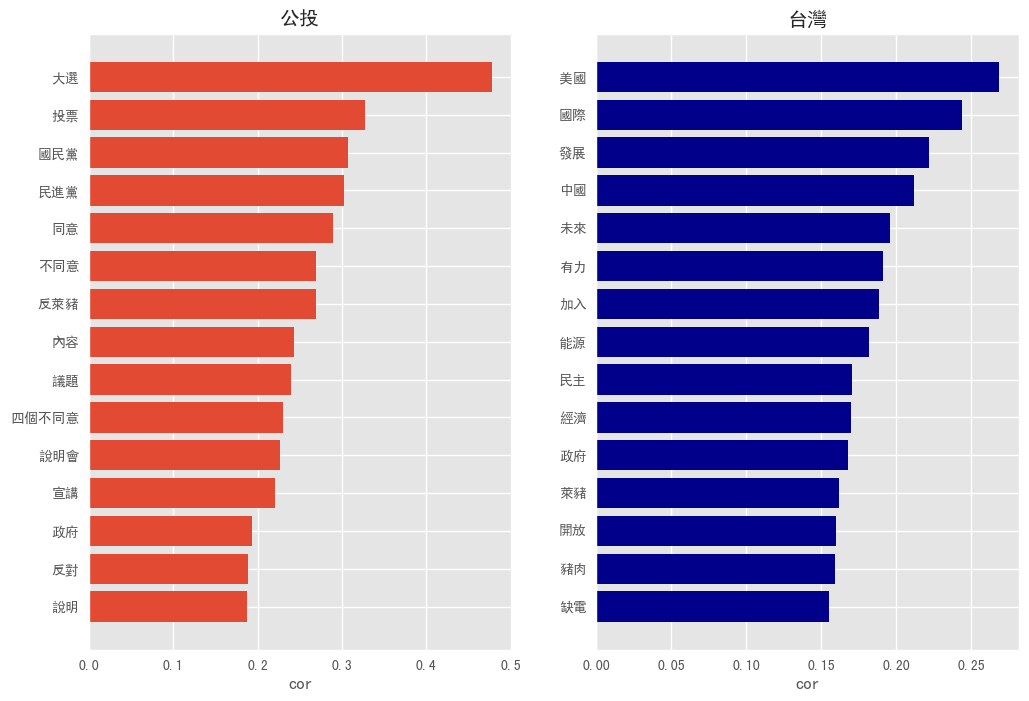

In [151]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('公投')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('台灣')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

plt.show()

### 7.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [152]:
bigram_df[bigram_df["cor"]>0.4]

word word2    n       cor
0      公投    大選  672  0.477547
4    行政院長   蘇貞昌  140  0.727887
5      總統   蔡英文  138  0.554087
8      台北    報導  129  0.486713
13     主席   朱立倫  115  0.568930
..    ...   ...  ...       ...
388    源頭    管理   19  0.549363
392    營養    午餐   19  0.789194
464    廠長   王伯輝   18  0.554943
468    燃煤    燃氣   17  0.407152
481    乙型    受體   17  0.937152

[70 rows x 4 columns]

In [153]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [154]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

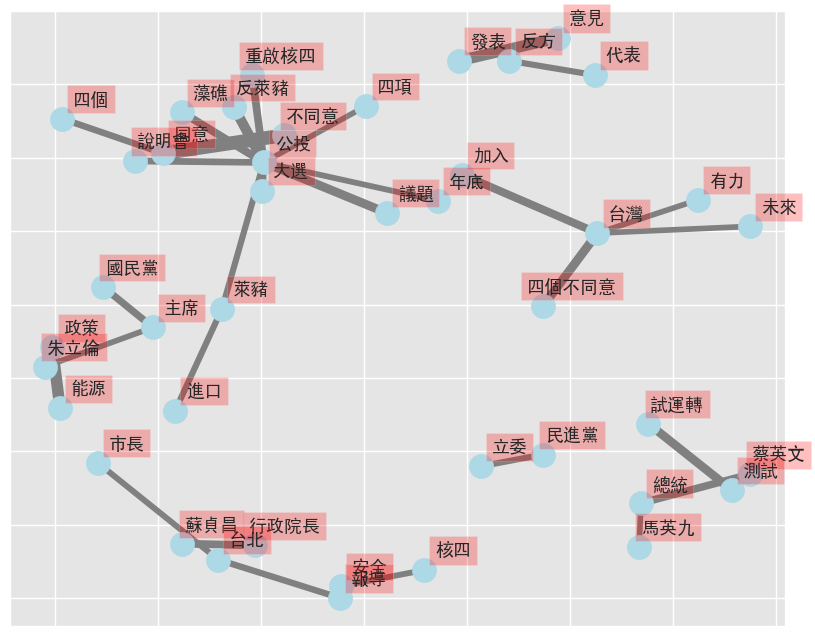

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示    
plt.show()

- 左上為總統為主 右上大致為公投主題 下面為黨派口號

## 8. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  

In [156]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [157]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

一一  一丁點  一三廠  一上台  一上場  一下子  一不小心  一中  一串  一九  ...  龐大  龐貝城  龔盈  龜兒子  龜山  \
0   0    0    0    0    0    0     0   0   0   0  ...   0    0   0    0   0   
1   0    0    0    0    0    0     0   0   0   0  ...   0    0   0    0   0   
2   0    0    0    0    0    0     0   0   0   0  ...   0    0   0    0   0   
3   0    0    0    0    0    0     0   0   0   0  ...   0    0   0    0   0   
4   0    0    0    0    0    0     0   0   0   0  ...   0    0   0    0   0   

   龜山島  龜縮  龜速  龜頭  龜龜  
0    0   0   0   0   0  
1    0   0   0   0   0  
2    0   0   0   0   0  
3    0   0   0   0   0  
4    0   0   0   0   0  

[5 rows x 34479 columns]

In [158]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


一一  一丁點  一三廠  一上台  一上場  一下子  一不小心   一中   一串   一九  ...   龐大  龐貝城   龔盈  龜兒子  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    龜山  龜山島   龜縮   龜速   龜頭   龜龜  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34479 columns]

In [159]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

- 找和第一篇文章相似的其他文章

In [160]:
print(tfidf.toarray()[1377])
cos_df = cosine_similarity(tfidf.toarray()[1377])

[0. 0. 0. ... 0. 0. 0.]


In [161]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity                      artTitle
1377        1.000000              [問卦]公投沒過核四直接除役如何
1261        0.308172              [問卦]核四封存之後經過了什麼？
1014        0.275559             [問卦]核四一年要花多少保養費用？
1394        0.250646             Re:[問卦]核四公投應該不會過了
1912        0.247565    Re:[新聞]台電嚴正聲明：「核四重啟初步規劃書」非
252         0.231621     Re:[新聞]蘇揆：重啟核四根本騙人馬英九封存又喊
1684        0.231401         [問卦]核四每年花好幾億維護費都在做什麼？
1690        0.227947             [問卦]核四公投沒過還會繼續封存嗎
2102        0.220377        [問卦]核四的維護費不是拿來準備重啟用的嗎？
1065        0.211129  Re:[新聞]蘇貞昌：國民黨封存核四浪費3000億1度電

## 9. 字詞分類

In [162]:
referendum = MetaData.copy()
referendum.head(1)

artTitle     artDate   artTime  \
0  [新聞]誰該下台僅次蘇貞昌和陳時中陳吉仲：能  2021/10/18  04:56:49   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....  luckyban  Gossiping   

   commentNum  push  boo                                           sentence  \
0          26     7   12  誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月日記者許展溢台北報導遠見日前公布國內政經...   

                                                word  
0  [下台, 僅次, 蘇貞昌, 吉仲能, 光榮, 年月日, 記者, 許展, 台北, 報導, 遠見...

In [163]:
# 看看有幾篇文章
print(f"number of posts: {referendum.shape[0]}")

number of posts: 2892


In [164]:
# 篩選需要的欄位
referendum['content'] =referendum['artTitle'] + referendum['sentence']
referendum = referendum.dropna() #去掉空白欄位
data = referendum[['content','artUrl']] #文章內容 文章連結data.head(3)

# 把句子切開
data['sentence'] = data.apply(lambda row : clean(row['content']), axis=1) #把句子切開
data = data[['sentence','artUrl']].explode("sentence")
data['document'] = range(0, len(data))
data.head(3)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


sentence  \
0  []誰該下台僅次蘇貞昌和陳時中陳吉仲：能誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月...   
1  [問卦]核四如果運轉會怎樣？核四花了一堆錢做出來的拼裝核電廠目前檯面上的政客都沒人敢開目前核...   
2  Re:[問卦]核四如果運轉會怎樣？馬政府時期反萊牛自己執政萊豬萊牛一起開放反糖衣毒藥自己執政...   

                                              artUrl  document  
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....         0  
1  https://www.ptt.cc/bbs/Gossiping/M.1634552359....         1  
2  https://www.ptt.cc/bbs/Gossiping/M.1634553019....         2

In [165]:
# 看看有幾個句子
print(f"total sentences: {data.shape[0]}")

total sentences: 2892


## 9.1 字詞分類-斷詞

In [166]:
def load_stop_words(path):
    with open(path , encoding = 'UTF-8') as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,stop_dict):
    
    # 去除noise 斷詞
    #jieba.load_userdict(user_dict) # 客製化字典    
    #sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [167]:
# 這裡會跑比較久
stop_path = './dict/stopwords.txt'

# 把句子切開，待會丟DTM
data['clean_txt'] = data.apply(lambda row : get_tokens(row['sentence'],stop_path), axis=1) 
data.head(5)

sentence  \
0  []誰該下台僅次蘇貞昌和陳時中陳吉仲：能誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月...   
1  [問卦]核四如果運轉會怎樣？核四花了一堆錢做出來的拼裝核電廠目前檯面上的政客都沒人敢開目前核...   
2  Re:[問卦]核四如果運轉會怎樣？馬政府時期反萊牛自己執政萊豬萊牛一起開放反糖衣毒藥自己執政...   
3  Re:[問卦]核四如果運轉會怎樣？首先有個人會餓死但如果抵擋不住誘惑的話也許還會活著然後台灣...   
4  [問卦]太魯閣礦業法農地工廠...等，還記得嗎?好奇問礦業法工輔法普悠瑪太魯閣囤房稅居住正義...   

                                              artUrl  document  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....         0   
1  https://www.ptt.cc/bbs/Gossiping/M.1634552359....         1   
2  https://www.ptt.cc/bbs/Gossiping/M.1634553019....         2   
3  https://www.ptt.cc/bbs/Gossiping/M.1634553351....         3   
4  https://www.ptt.cc/bbs/Gossiping/M.1634556691....         4   

                                           clean_txt  
0  下台 僅次 蘇貞昌 中陳吉仲 下台 僅次 蘇貞昌 吉仲能 光榮 年月日 記者 許展 台北 報...  
1  問卦 核四 運轉 核四花 拼裝 核電廠 目前 檯面 政客 沒人敢 目前 核一 除役 核二再 ...  
2  Re 問卦 核四 運轉 政府 時期 反萊牛 執政 萊豬 萊牛 開放 糖衣 毒藥 執政 糖衣 ...  
3  Re 問卦 核四 運轉 餓死 抵擋不住 誘惑 也許 活著 台灣能 減少 排放 世界 看見 台...  
4  問卦 太魯閣 礦業法 農地 工廠 記得 好奇 礦業法 工輔法 普悠瑪 太魯閣 房稅 居住 正...

In [168]:
# 把字詞斷開，待會情緒分析
token_df = data[['document','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


document  word
0         0    下台
1         0    僅次
2         0   蘇貞昌
3         0  中陳吉仲
4         0    下台

In [169]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 35085


### 9.2 算出情緒分數，將正負面文章分類
+ 待會分類任務要用的

- 讀入liwc的字典，轉換成dataframe

In [170]:
def load_senti():
    filepath = ['ntusd-negative','ntusd-positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split("\n"),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

用 `load_senti` 獲得情緒字典的 dataframe，可以自行調整加上新的正面或負面詞彙

In [171]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
neg_added = ["不同意"] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "ntusd-negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()
data_liwc.head(5)

word      sentiments
0        不同意  ntusd-negative
1          幹  ntusd-negative
2      一下子爆發  ntusd-negative
3  一下子爆發的一連串  ntusd-negative
4        一巴掌  ntusd-negative

將剛剛字詞斷開後的`token_df`和`df_liwc`合併，算出每個詞的情緒，得到`senti_count`資料框。

In [172]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['ntusd-positive'] >= senti_count['ntusd-negative'], 'pos','neg')
senti_count.head(5)

document  ntusd-negative  ntusd-positive label
0         0             2.0             8.0   pos
1         1             3.0             0.0   neg
2         2             2.0             1.0   neg
3         3             6.0             1.0   neg
4         4             0.0             3.0   pos

### 9.3 將情緒標籤加回原本的資料集
+ 把情緒標籤加回去
+ 如果該篇文章沒有情緒字，就算是中性的文章

將剛剛得到的`senti_count`資料框和一開始的`data`資料集合併，得到每句話的情緒。

In [173]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

sentence  \
0  []誰該下台僅次蘇貞昌和陳時中陳吉仲：能誰該下台僅次蘇貞昌和陳時中陳吉仲能排在一起是光榮年月...   
1  [問卦]核四如果運轉會怎樣？核四花了一堆錢做出來的拼裝核電廠目前檯面上的政客都沒人敢開目前核...   
2  Re:[問卦]核四如果運轉會怎樣？馬政府時期反萊牛自己執政萊豬萊牛一起開放反糖衣毒藥自己執政...   
3  Re:[問卦]核四如果運轉會怎樣？首先有個人會餓死但如果抵擋不住誘惑的話也許還會活著然後台灣...   
4  [問卦]太魯閣礦業法農地工廠...等，還記得嗎?好奇問礦業法工輔法普悠瑪太魯閣囤房稅居住正義...   

                                              artUrl  document  \
0  https://www.ptt.cc/bbs/Gossiping/M.1634533011....         0   
1  https://www.ptt.cc/bbs/Gossiping/M.1634552359....         1   
2  https://www.ptt.cc/bbs/Gossiping/M.1634553019....         2   
3  https://www.ptt.cc/bbs/Gossiping/M.1634553351....         3   
4  https://www.ptt.cc/bbs/Gossiping/M.1634556691....         4   

                                           clean_txt label  
0  下台 僅次 蘇貞昌 中陳吉仲 下台 僅次 蘇貞昌 吉仲能 光榮 年月日 記者 許展 台北 報...   pos  
1  問卦 核四 運轉 核四花 拼裝 核電廠 目前 檯面 政客 沒人敢 目前 核一 除役 核二再 ...   neg  
2  Re 問卦 核四 運轉 政府 時期 反萊牛 執政 萊豬 萊牛 開放 糖衣 毒藥 執政 糖衣 ...   neg  
3  Re 問卦 核四 運轉 餓死 抵擋不住 誘惑 也許 活著 台灣能 減少 排放 世界 看見 台...   neg  
4  問卦 太魯閣 礦業法 農地 工廠 記得 好奇 礦業法 工輔法 普悠瑪 太魯閣 房稅 居住 正...   pos

### 9.4 資料集基本檢視

In [174]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 2892
total sentences: 2892


In [175]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

label word  size
29134   pos   公投  2350
30538   pos   台灣  1806
37786   pos  民進黨   942
31494   pos  國民黨   939
37025   pos   核四   875

In [176]:
# 選出兩類文章最高的20個字
top_n = 20
book1 = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
book2 = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
book1.head(5)

label word  size
13764   neg   核能   471
7950    neg   安全   478
17395   neg   知道   485
20395   neg   表示   487
7360    neg   大選   488

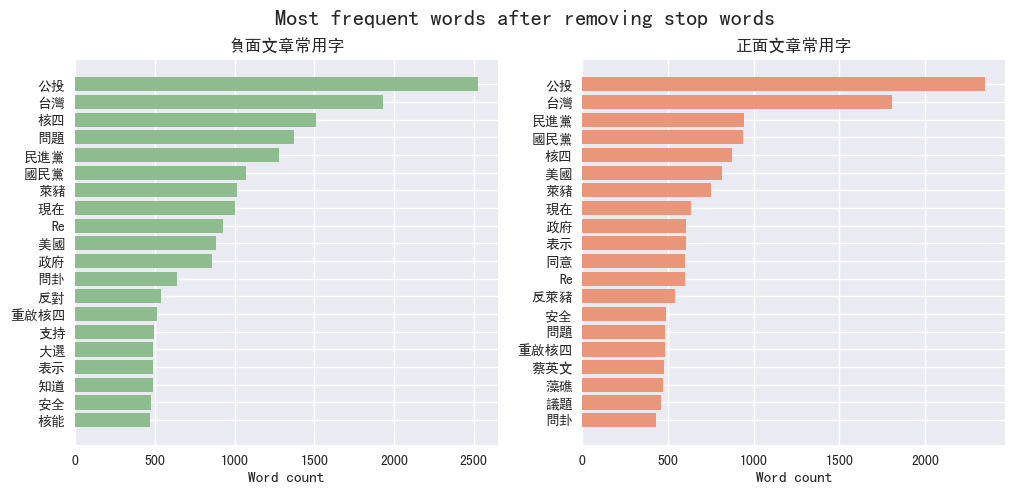

In [177]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(book1['word'],book1['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(book2['word'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)
plt.show()

## 9.5 將資料切成訓練集與測試集
### 9.5.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [178]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [179]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neg    56.085754
pos    42.081604
neu     1.832642
Name: label, dtype: float64

train percentage :
neg    56.077075
pos    42.094862
neu     1.828063
Name: label, dtype: float64

test percentage :
neg    56.105991
pos    42.050691
neu     1.843318
Name: label, dtype: float64


## 10. 將文章轉為 DTM

In [180]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [181]:
corpus = dtf_train["clean_txt"]

+ 過濾詞頻比較

In [182]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [183]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 2024 words: 10000 (10000)
with term cut off: posts 2024 words: 2385 (2385)


<2024x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 120233 stored elements in Compressed Sparse Row format>

In [184]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [185]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.75
Auc: 0.86
Detail:
              precision    recall  f1-score   support

         neg       0.76      0.82      0.79       487
         neu       0.50      0.06      0.11        16
         pos       0.73      0.68      0.70       365

    accuracy                           0.75       868
   macro avg       0.66      0.52      0.54       868
weighted avg       0.74      0.75      0.74       868



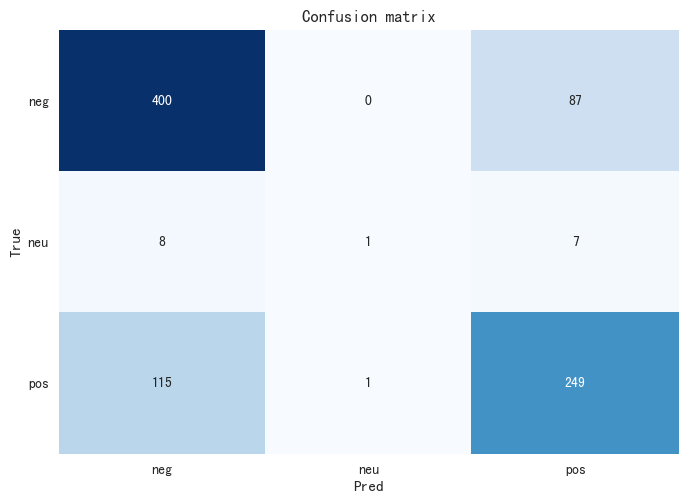

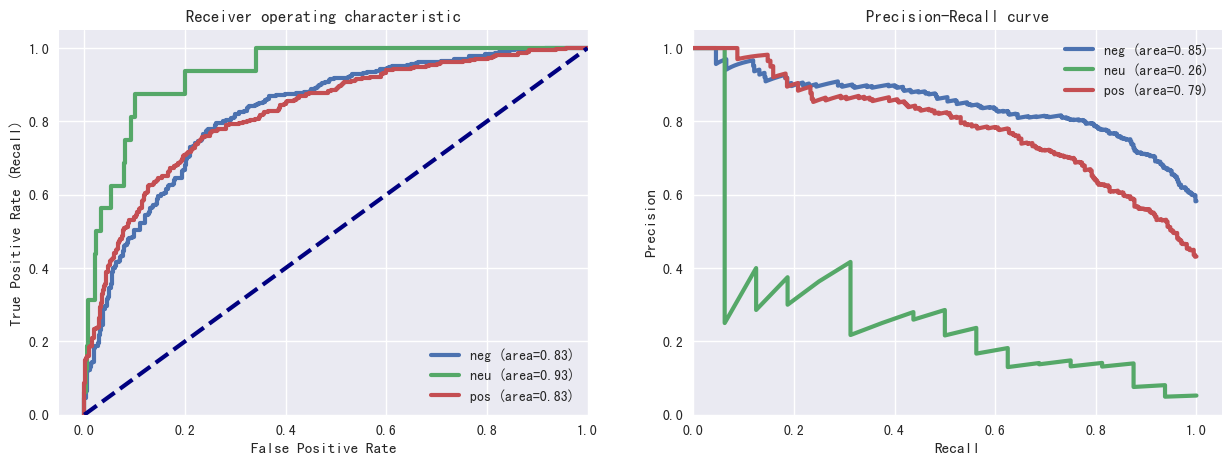

In [186]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [187]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["clean_txt"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.74
Auc: 0.85
Detail:
              precision    recall  f1-score   support

         neg       0.76      0.79      0.78       487
         neu       0.50      0.19      0.27        16
         pos       0.71      0.69      0.70       365

    accuracy                           0.74       868
   macro avg       0.66      0.56      0.58       868
weighted avg       0.73      0.74      0.74       868



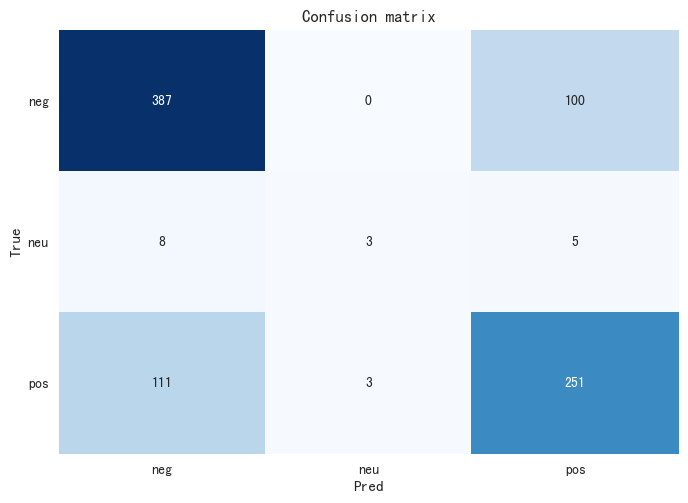

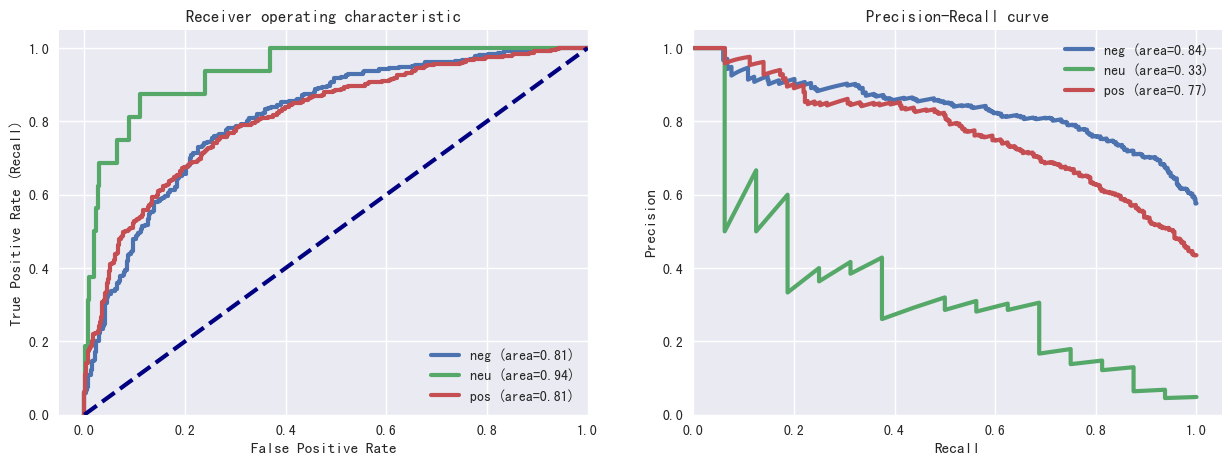

In [188]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 10.1 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [189]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [190]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

ROC 適用二元分類，故將每個類別(正面、中性、負面情緒)的預測都視作為一個二元分類，以下比較上面各模型的分類效果

### step 1 定義 vectorizer

In [191]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

### step 2 定義 classifier

In [192]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [193]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [194]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 11.比較不同模型和資料組合的訓練結果

### 11.1 Model Building : logistic regression
logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)
+ [參考: Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

model type: CV + logistic regression


/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


time costing: 1.5169572830200195
Accuracy: 0.75
Auc: 0.86
Detail:
              precision    recall  f1-score   support

         neg       0.76      0.82      0.79       487
         neu       0.50      0.06      0.11        16
         pos       0.73      0.68      0.70       365

    accuracy                           0.75       868
   macro avg       0.66      0.52      0.54       868
weighted avg       0.74      0.75      0.74       868



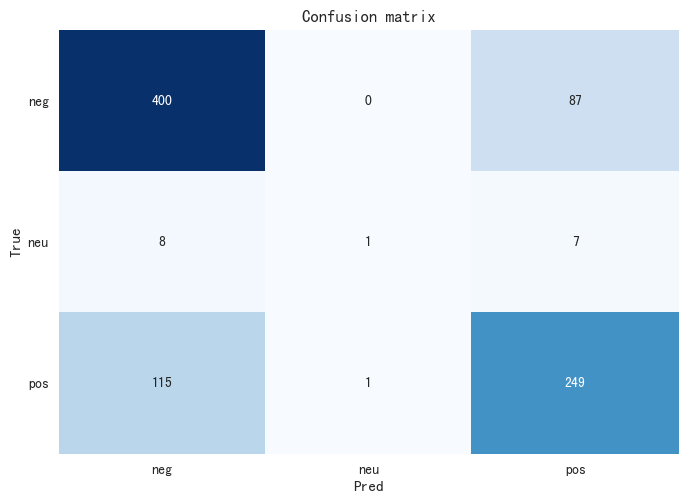

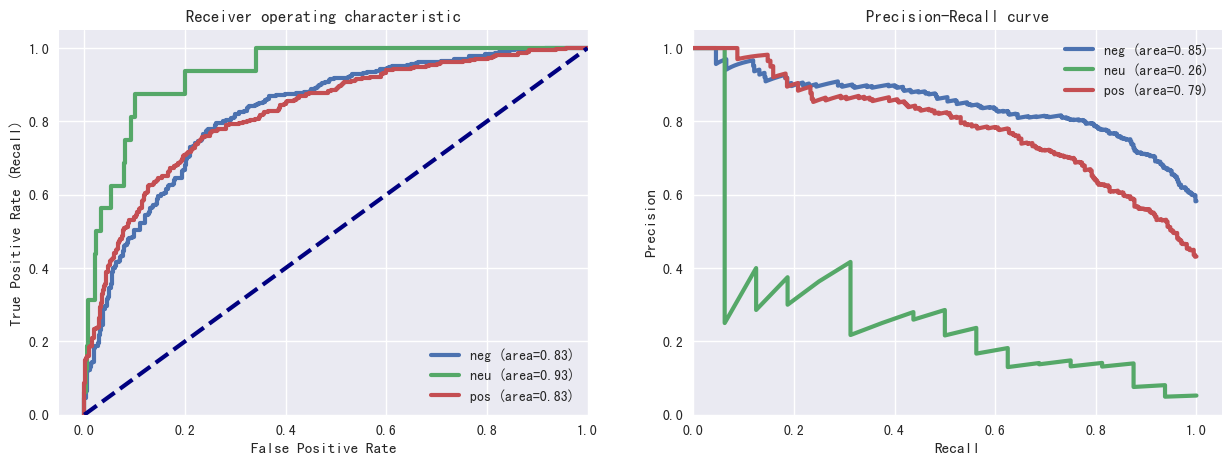

In [195]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression
time costing: 0.8055787086486816
Accuracy: 0.75
Auc: 0.86
Detail:
              precision    recall  f1-score   support

         neg       0.73      0.88      0.80       487
         neu       0.00      0.00      0.00        16
         pos       0.78      0.60      0.68       365

    accuracy                           0.75       868
   macro avg       0.50      0.49      0.49       868
weighted avg       0.74      0.75      0.73       868



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


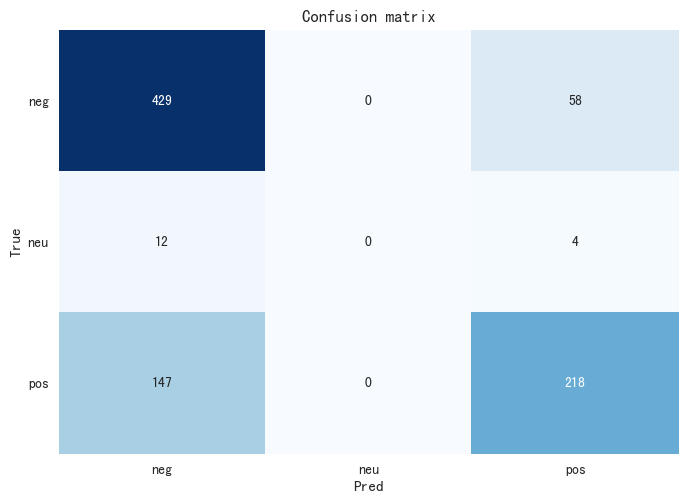

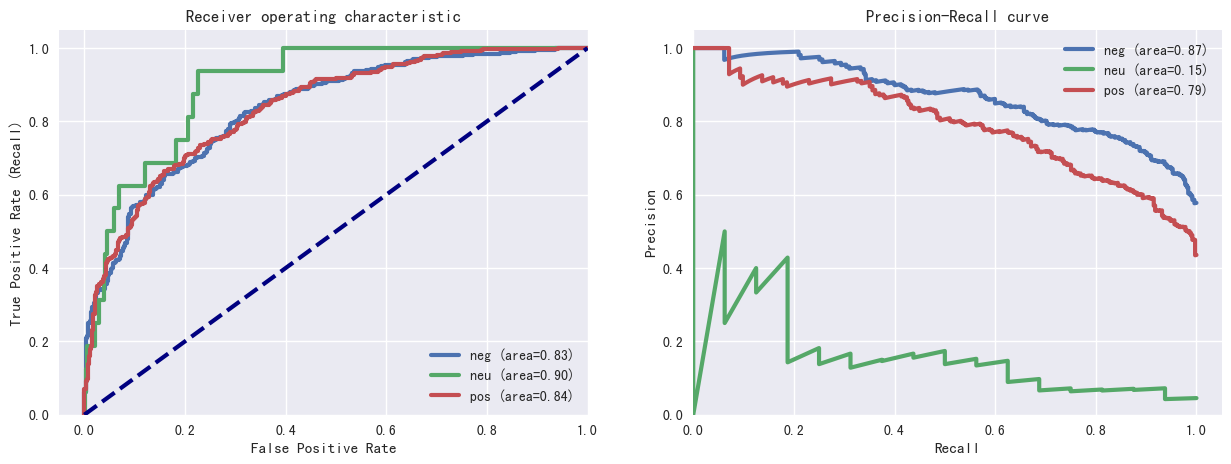

In [196]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 11.2 Model Building : SVC

model type: CV + SVC
time costing: 12.112993240356445
Accuracy: 0.66
Auc: 0.82
Detail:
              precision    recall  f1-score   support

         neg       0.64      0.90      0.75       487
         neu       0.00      0.00      0.00        16
         pos       0.73      0.38      0.50       365

    accuracy                           0.66       868
   macro avg       0.46      0.43      0.42       868
weighted avg       0.67      0.66      0.63       868



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


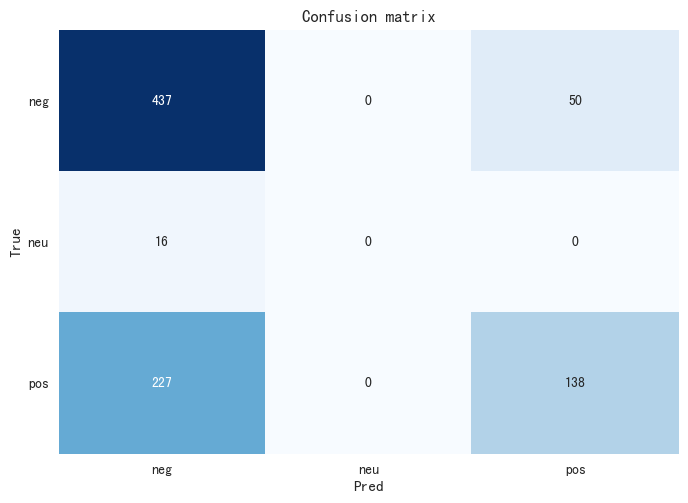

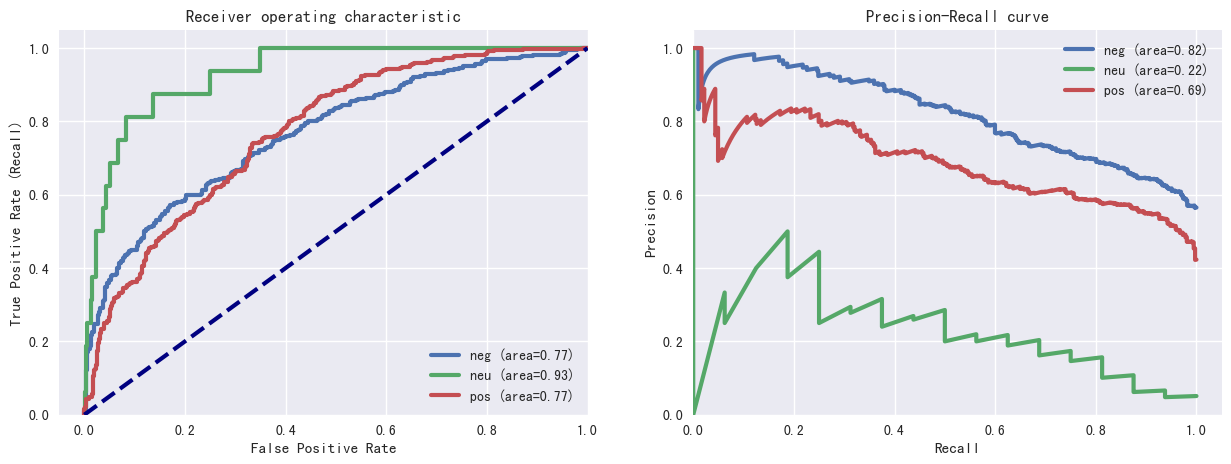

In [197]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 15.632226467132568
Accuracy: 0.71
Auc: 0.83
Detail:
              precision    recall  f1-score   support

         neg       0.69      0.91      0.78       487
         neu       0.00      0.00      0.00        16
         pos       0.78      0.48      0.60       365

    accuracy                           0.71       868
   macro avg       0.49      0.46      0.46       868
weighted avg       0.71      0.71      0.69       868



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


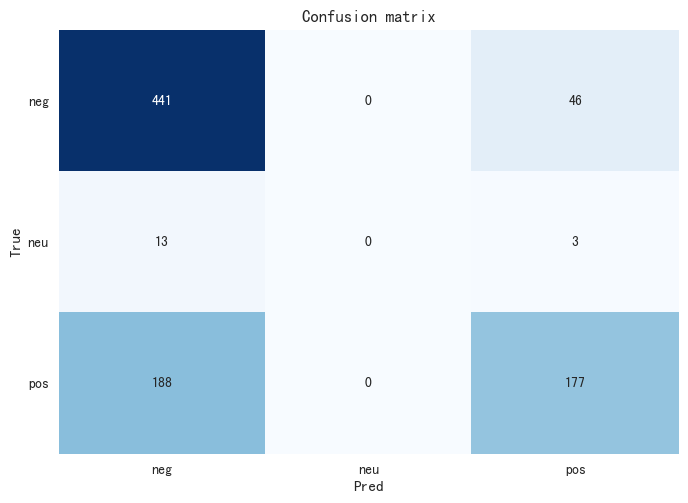

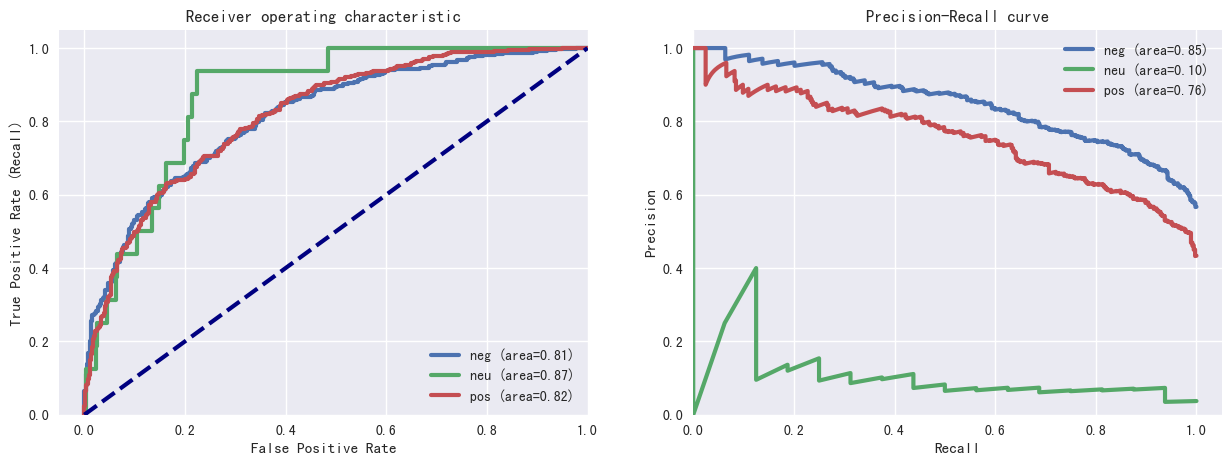

In [198]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 11.3 Model Building : RandomForest

model type: CV + RandomForest
time costing: 1.838831901550293
Accuracy: 0.7
Auc: 0.84
Detail:
              precision    recall  f1-score   support

         neg       0.68      0.88      0.77       487
         neu       0.00      0.00      0.00        16
         pos       0.76      0.49      0.60       365

    accuracy                           0.70       868
   macro avg       0.48      0.46      0.46       868
weighted avg       0.70      0.70      0.68       868



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


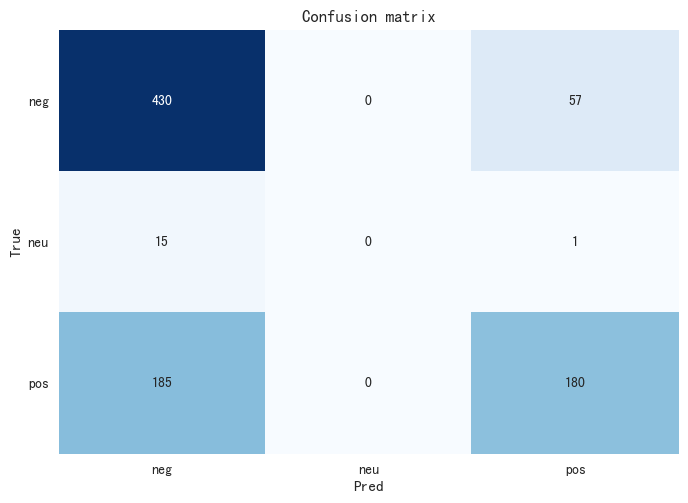

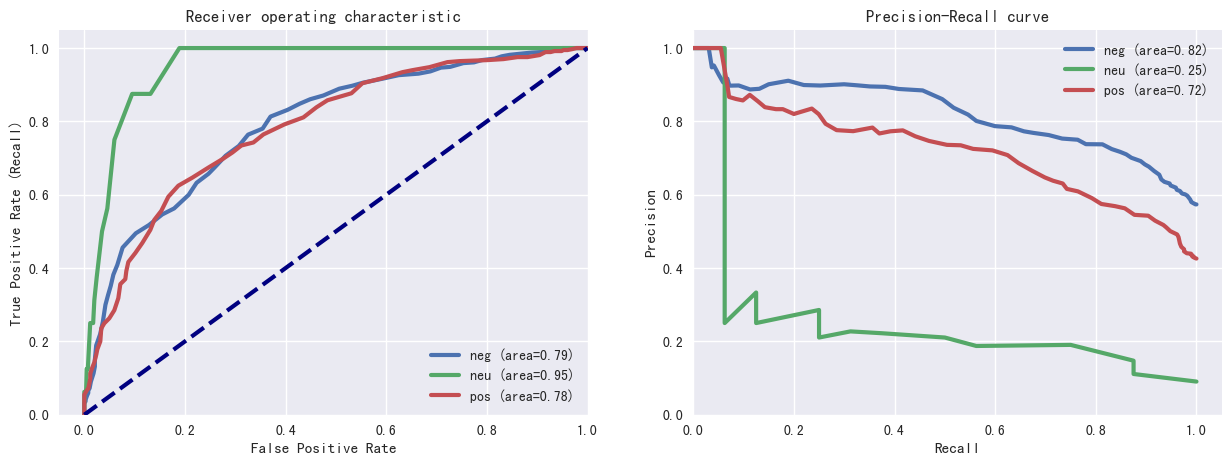

In [199]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 1.8371543884277344
Accuracy: 0.7
Auc: 0.8
Detail:
              precision    recall  f1-score   support

         neg       0.68      0.88      0.77       487
         neu       0.00      0.00      0.00        16
         pos       0.75      0.50      0.60       365

    accuracy                           0.70       868
   macro avg       0.48      0.46      0.46       868
weighted avg       0.70      0.70      0.68       868



/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


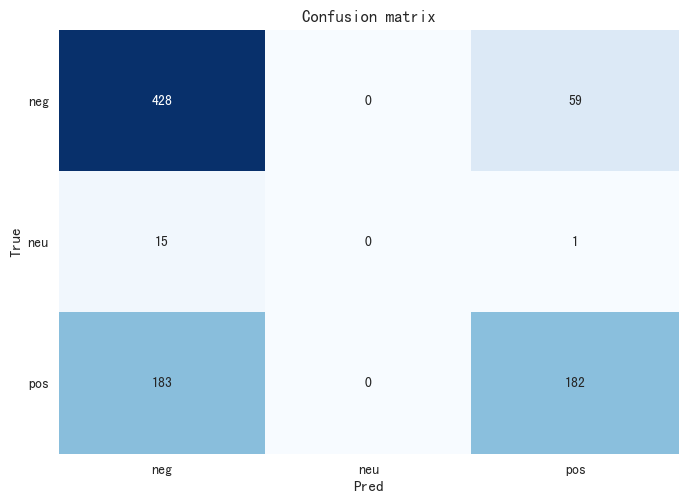

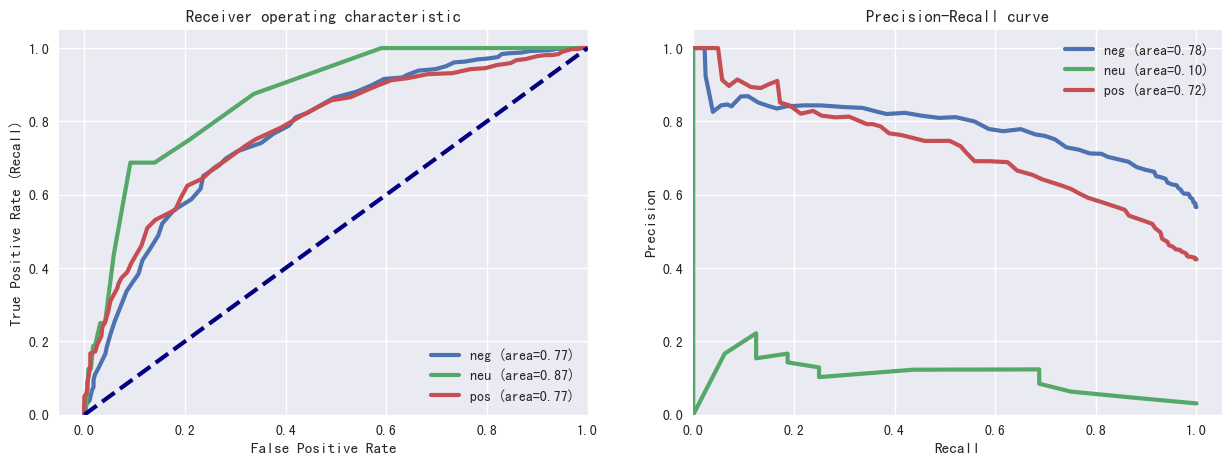

In [200]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 11.4 預測結果探索
+ 11.4.1 各字詞特徵的estimate係數
+ 11.4.2 查看分類錯誤的句子
+ 11.4.3 比較不同模型的ROC

查看模型預測結果

In [201]:
result_df.sort_values(by=['Accuracy'], ascending=False)

model_type  Accuracy       AUC
0      CV + logistic regression  0.748848  0.861357
1  TF-IDF + logistic regression  0.745392  0.855469
3                  TF-IDF + SVC  0.711982  0.832897
4             CV + RandomForest  0.702765  0.841691
5         TF-IDF + RandomForest  0.702765  0.802742
2                      CV + SVC  0.662442  0.823240

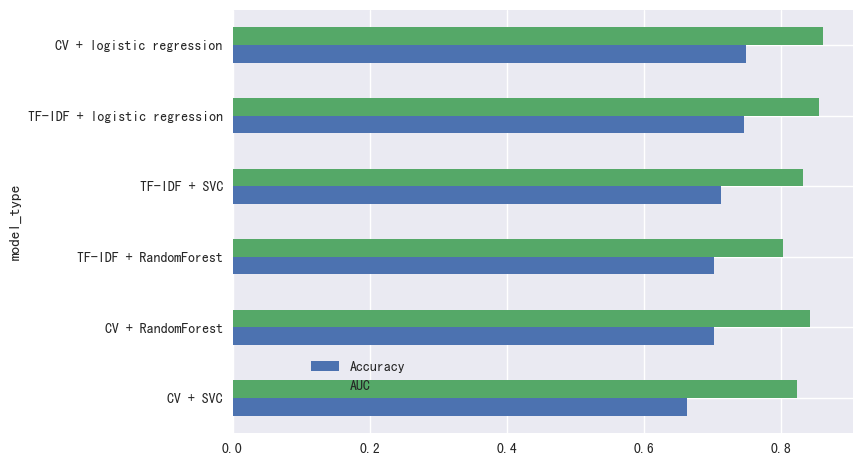

In [202]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

### 11.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 11.1 的 logistic regression + cv tokenizer 為例

In [203]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [204]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

neg       neu       pos
10   -0.051980 -0.059542 -0.234116
11   -0.139460  0.004356  0.034174
1218  0.064435 -0.079376  0.040621
13   -0.163586 -0.077918  0.139023
14   -0.168484  0.004911  0.102069

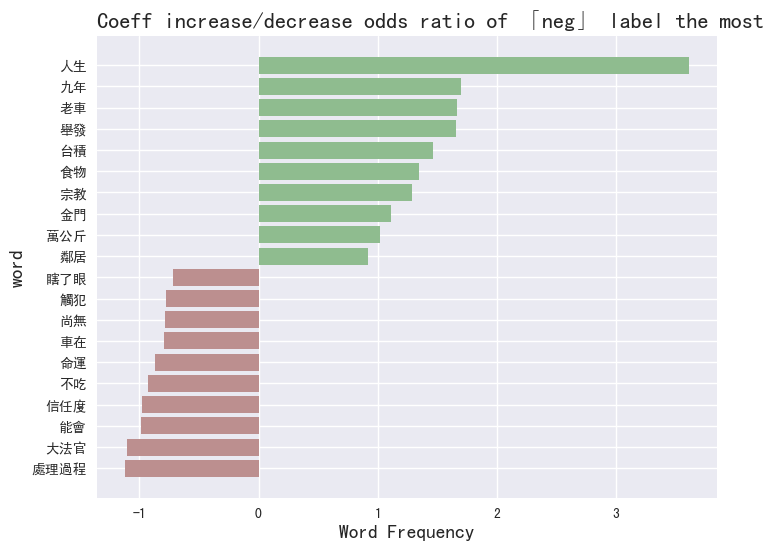

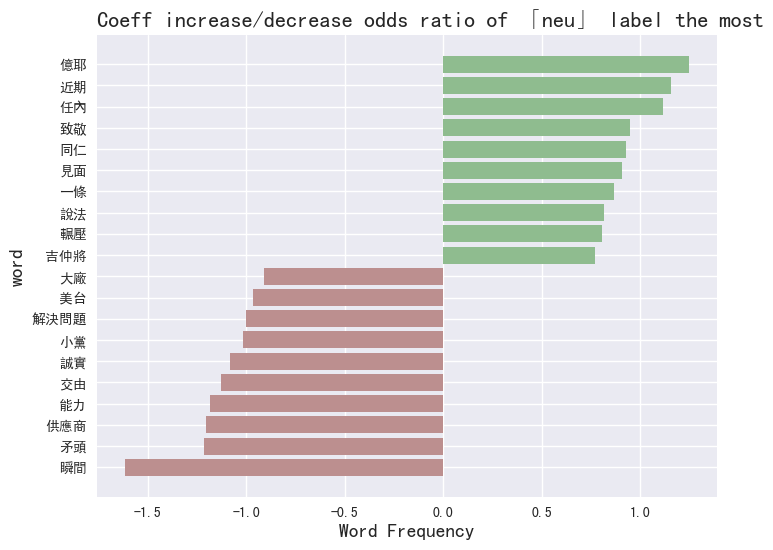

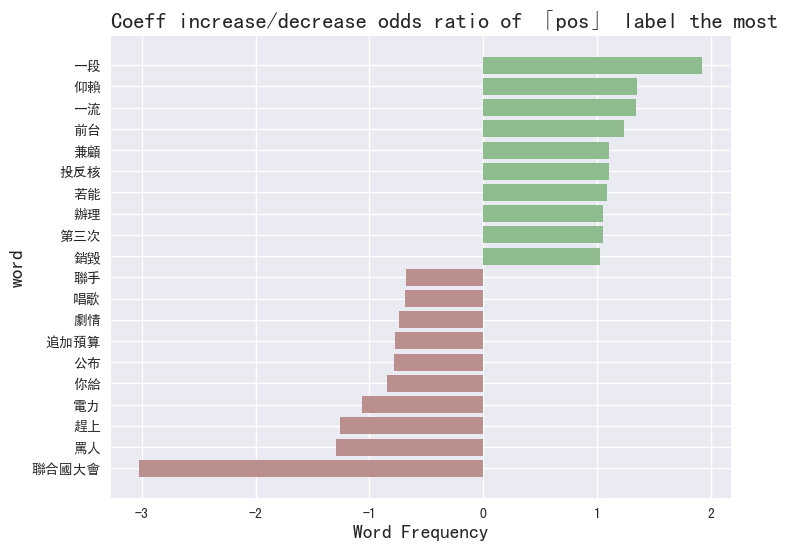

In [205]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

### 看一下含特定關鍵字的句子

In [206]:
keyword_list = ['跋扈','林右昌','修憲蘇'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

document                                           sentence  \
136        136  Re:[]四個不同意蔡英文下軍令：全力阻止公投我覺得基捷路線才應該辦公投吧交通部長說要看民意...   
765        765  Re:[]林右昌拋「大基隆市」構想侯友宜：這是把瑞芳貢寮雙溪平溪萬里都給基隆朱立倫侯友宜都解...   
1020      1020  []反核四重啟林右昌：非核是非走不可的方記者盧賢秀基隆報導四大公投案連宜蘭縣長林姿妙也反核四...   
1023      1023  Re:[]反核四重啟林右昌：非核是非走不可的方旗靈王就是不甘寂寞啦一下北海市一下基隆捷運一下...   
1024      1024  Re:[]反核四重啟林右昌：非核是非走不可的方依照版上擁核的立場那就一個縣市一座核五蓋台中核...   
1028      1028  Re:[]反核四重啟林右昌：非核是非走不可的方能源轉型成新能源就是一場騙了八年還不夠的騙局燒...   
1029      1029  Re:[]反核四重啟林右昌：非核是非走不可的方被民進黨騙一次就算了再被騙第二次真的要去跳樓簡...   
2165      2165  [討論]陳薇仲基隆市議員：基隆捷運陳薇仲基隆市議員被消失的報告案基隆捷運市府出來講基隆市議會...   
2304      2304  []柯文哲批基捷變更路線是炒地皮公投成藍綠聯合報標題柯文哲批基捷變更路線是炒地皮公投成藍綠對...   
2727      2727  []黃士修恐嚇范世平：囂張跋扈藍營豬隊友新頭殼標題黃士修恐嚇范世平囂張跋扈藍營豬隊友朱立倫恐...   

                                                 artUrl label  
136   https://www.ptt.cc/bbs/Gossiping/M.1635325040....   pos  
765   https://www.ptt.cc/bbs/Gossiping/M.1636049155....   neg  
1020  https://www.ptt.cc/bbs/Gossiping/M.1636435530....   pos  
1023  https://www.ptt.cc/bbs/Gossiping/M.1636435821....   pos  
1024  https://www.ptt.cc/bbs/Gossiping/M.1636436194....   neu  
1028  https://www.ptt.cc/bbs/Gossiping/M.1636441961....   neg  
1029  https://www.ptt.cc/bbs/Gossiping/M.1636443059....   neg  
2165  https://www.ptt.cc/bbs/HatePolitics/M.16352412...   pos  
2304  https://www.ptt.cc/bbs/HatePolitics/M.16356668...   neg  
2727  https://www.ptt.cc/bbs/HatePolitics/M.16373334...   neg

### 11.4.2 查看分類錯誤的句子

In [207]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 183
neg label predicted wrong: 59
neu label predicted wrong: 16


/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [208]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

sentence  \
612   Re:[問卦]核四若重啟，核廢料放哪？還還不簡單這次核四重啟公投看哪邊成贊成票最多那邊就是最...   
1489  Re:[爆卦]反核四方唯一戰力逐字稿以前說台灣錢淹腳目這個台灣是不是比想像中的更有錢前有把億...   
1311  [問卦]核四可以收門票開放參觀了吧？聽處長說啦核四是一台拼裝車一邊蓋一邊改圖所以有些機器進來...   
2355  Re:[]4公投民眾黨態度轉彎兩好柯文哲批：題目這個題目自由時報寫得不夠生動要看這篇四大公投...   
726   Re:[]不甩外交部打臉！王美花再強調「禁萊豬甚麼時候針對萊克多巴胺建議參考的許可殘留劑量變...   

                                                 artUrl label predict  
612   https://www.ptt.cc/bbs/Gossiping/M.1635856456....   pos     neg  
1489  https://www.ptt.cc/bbs/Gossiping/M.1637318128....   pos     neg  
1311  https://www.ptt.cc/bbs/Gossiping/M.1637259460....   pos     neg  
2355  https://www.ptt.cc/bbs/HatePolitics/M.16357685...   pos     neg  
726   https://www.ptt.cc/bbs/Gossiping/M.1636004132....   pos     neg

In [209]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

sentence  \
2292  Re:[討論]「公投綁大選」到底好不好？？每件事情一定有好有壞先不討論那些腦袋只剩下政黨的言...   
2726  []黃士修提核四重啟初步規劃書台電：完全黃士修提核四重啟初步規劃書台電完全造謠中央社記者曾智...   
2086  Re:[]1218公投》最新民調搶先曝光吳子嘉驚：先問一句公投有效力嗎全民共識就會按表操課嗎...   
809   []批藍用公投做政治鬥爭蘇揆：菜刀可切菜標題內文四項公投將在月進行投票行政院長蘇貞昌日前抨擊...   
2564  [討論]ETtoday公投民調剛出爐的公投民調同意不同意反萊豬進口公投綁大選珍愛藻礁重啟核四...   

                                                 artUrl label predict  
2292  https://www.ptt.cc/bbs/HatePolitics/M.16356496...   neg     pos  
2726  https://www.ptt.cc/bbs/HatePolitics/M.16373288...   neg     pos  
2086  https://www.ptt.cc/bbs/Gossiping/M.1637986503....   neg     pos  
809   https://www.ptt.cc/bbs/Gossiping/M.1636094492....   neg     pos  
2564  https://www.ptt.cc/bbs/HatePolitics/M.16364041...   neg     pos

In [210]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

sentence  \
1061  [問卦]蛤!?核四拼裝車台鐵EMU900也拼裝車?台鐵的新車車被爆冷氣空調漏水被發現韓國製的...   
930   [問卦]美豬進口後都用在哪裡了？根據衛福部食藥署的豬肉儀表板自累計至為止美國豬肉進口了噸美國...   
1340  [問卦]重啟核四...所以說那個棒子呢？吶吶吶要重啟核四的話燃料棒要插進去反應爐引發連鎖反應...   
1684  [問卦]核四每年花好幾億維護費都在做什麼？為什麼核四不運轉還要每年花好幾億去維護花這麼多維護...   
1015  [問卦]臺灣勢必會漲電價是不是不要核電就漲電價就那麼簡單講什麼核電核四核廢料怎樣核安怎樣說到...   

                                                 artUrl label predict  
1061  https://www.ptt.cc/bbs/Gossiping/M.1636543660....   neu     neg  
930   https://www.ptt.cc/bbs/Gossiping/M.1636252083....   neu     neg  
1340  https://www.ptt.cc/bbs/Gossiping/M.1637282958....   neu     neg  
1684  https://www.ptt.cc/bbs/Gossiping/M.1637479513....   neu     neg  
1015  https://www.ptt.cc/bbs/Gossiping/M.1636434198....   neu     neg

### 11.4.3 比較不同模型的ROC

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

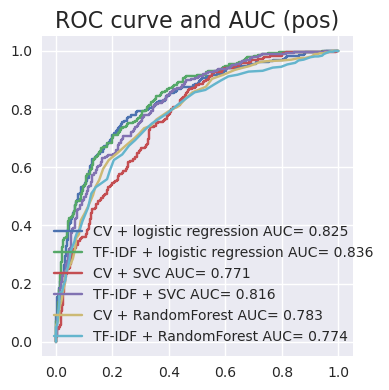

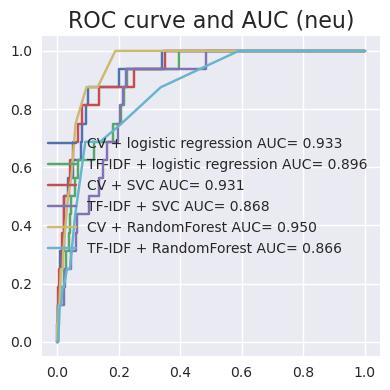

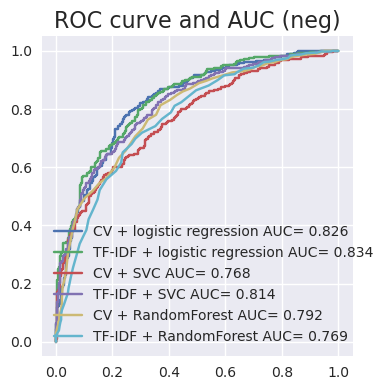

In [211]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(4, 4))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

- pos為 tf-idf + 邏輯式回歸，表現最好
- neu為 tf-idf + 隨機森林，表現最好
- neg為 tf-idf + 邏輯式回歸，表現最好

- 總結
- 1.觀察文字雲、正負情緒折線圖以及情緒代表字後發現，造成鄉民負面情緒的原因包括：像是「核四」、「缺電」、「垃圾」（黃士修說過：核廢料跟家裡垃圾有臭味一樣，，包起來隔絕就好了，這句話，造成鄉民熱烈討論）等等，其中萊豬&美國也受到鄉民的關注

- 2.從詞性標註可以看出：涉及到的組織與人名最多是「蔡英文」、「民進黨」等，而國家則是台灣以及美國最多（可能在探討萊豬議題與台美關係）

- 3.總結在ptt上大多都是負面情緒，而我們認為負面聲量會遠遠高於正面聲量的原因可能有：
    + 1.公投綁大選 - 鄉民認為有開票開太晚、排隊排很久等影響
    + 2.重啟核四 - 核廢料議題遲遲尚未解決，也無法保證一定安全
    + 3.黨派互爭 - 各黨可能會派各自的水軍到PTT洗對方的負面文章
    + 4.萊豬方面 - 雖然說使用瘦肉精對於人類的健康有所影響，但使用萊豬的安全性我們也不得而知
    + 5.藻礁 - 如果蓋會破壞藻礁與生態系，如果不蓋台灣長期處在電力不足，若持續缺電會導致電費的價格有所提升